In [152]:
import pandas as pd
import numpy as np
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Goal

Increase Nuvei’s revenue by maximizing the potential of our users.

# Data

- *approved* transactions of users who made their first purchase between 01/04/2024 and 01/05/2024 with us --> we have a cohort of 1 month with 41,321 transaction (16,208 users)
- The data contains their first 4 months of purchases.

## Features

- payment_id: A unique identifier for each transaction.
- user_id: The unique identifier for each user in the dataset.
- merchant_id: The identifier for the merchant involved in the transaction.
- payment_timestamp: The date when the transaction was created.
- first_approved_payment_timestamp: The date the user joined the platform.
- total_amount_usd: The total value of the transaction in USD, representing the amount spent by the user.
- payment_instrument: The method of payment used in the transaction (e.g., Credit Card, PayPal, Apple Pay).
- currency: The currency used in the transaction (e.g., USD, AED, AUD).
- time_to_complete_payment: The time (in seconds) it took to complete the transaction.
- num_approved_payments_per_user: The number of approved transactions made by the user.
- total_approved_amount_usd_per_user: The total approved amount spent by the user in USD across all their transactions.
- country: The country of the user making the transaction.
- state: The state or region of the user, where applicable (for users from the US, for example).
- device_type: The type of device the user used for the transaction (e.g., mobile, PC).

In [2]:
df = pd.read_csv('/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/Home_Assignments/Nuvei_home_assignment/DS_Test_Dataset.csv')

In [3]:
df.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,total_approved_amount_usd_per_user,country,state,device_type
0,66675334,11008761,210,5/31/2024 23:56,5/31/2024 23:56,109.86,credit_card,CAD,7.045880,1,109.86,CA,NaN,pc
1,66675371,11008762,117,6/1/2024 0:00,6/1/2024 0:00,108.71,credit_card,USD,3.236956,1,108.71,US,DC,mobile
2,66675434,11008768,248,6/1/2024 0:07,6/1/2024 0:07,150.00,credit_card,USD,3.431595,1,150.00,US,MO,mobile
3,66675492,11008775,288,6/1/2024 0:12,6/1/2024 0:12,30.00,credit_card,USD,1.600267,1,30.00,US,TX,mobile
4,66675558,11008784,160,6/1/2024 0:18,6/1/2024 0:18,41.42,credit_card,EUR,2.335492,1,41.42,FR,NaN,mobile


In [4]:
df.shape

(41321, 14)

In [5]:
df.user_id.nunique()

16208

i see we have less user_id's than payment_id's

In [6]:
df.payment_id.nunique()

41321

the df is at payment_level as the number of payment_id's matches with the shape.

In [7]:
df.columns

Index(['payment_id', 'user_id', 'merchant_id', 'payment_timestamp',
       'first_approved_payment_timestamp', 'total_amount_usd',
       'payment_instrument', 'currency', 'time_to_complete_payment',
       'num_approved_payments_per_user', 'total_approved_amount_usd_per_user',
       'country', 'state', 'device_type'],
      dtype='object')

In [8]:
df.dtypes

payment_id                              int64
user_id                                 int64
merchant_id                             int64
payment_timestamp                      object
first_approved_payment_timestamp       object
total_amount_usd                      float64
payment_instrument                     object
currency                               object
time_to_complete_payment              float64
num_approved_payments_per_user          int64
total_approved_amount_usd_per_user    float64
country                                object
state                                  object
device_type                            object
dtype: object

In [9]:
(df.isna().sum()/df.isna().sum().sum()).sort_values(ascending=False)

state                                 0.999171
payment_instrument                    0.000414
device_type                           0.000414
payment_id                            0.000000
user_id                               0.000000
merchant_id                           0.000000
payment_timestamp                     0.000000
first_approved_payment_timestamp      0.000000
total_amount_usd                      0.000000
currency                              0.000000
time_to_complete_payment              0.000000
num_approved_payments_per_user        0.000000
total_approved_amount_usd_per_user    0.000000
country                               0.000000
dtype: float64

I see state has 99% missing values. Let's see first of all at what level should the model be (user or payment) and the importance of this feature in the model, and according to this decide if i should drop it or not.

# Workflow


## EDA

In [10]:
# how many payment_id's do we have per user?
df.groupby(['user_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False)

,user_id,payment_id
4681,11031911,275
10652,11062232,264
10346,11060763,183
16159,11092434,150
3105,11023684,139
...,...,...
6757,11042234,1
6758,11042238,1
6759,11042240,1
6761,11042252,1


In [11]:
df.groupby(['user_id'])['payment_id'].nunique().describe()

count    16208.000000
mean         2.549420
std          5.998501
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        275.000000
Name: payment_id, dtype: float64

In [12]:
# can we have multiple user_id for the same payment_id?
df.groupby(['payment_id'])['user_id'].nunique() #no

payment_id
66675334    1
66675371    1
66675434    1
66675492    1
66675558    1
           ..
69672855    1
69673681    1
69673750    1
69676107    1
69684451    1
Name: user_id, Length: 41321, dtype: int64

on average we have 2 payments per user. the distribution seems very skewed.

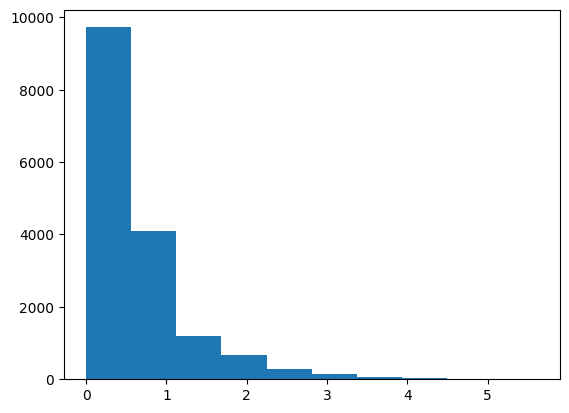

In [13]:
plt.hist(np.log(df.groupby(['user_id'])['payment_id'].nunique())) # using log to tackle skewness for better visualization
plt.show()

In [14]:
# how many merchant_id do you have per user_id and payment_id
merchants_per_user = df.groupby(['user_id'], as_index=False)['merchant_id'].nunique() # for each user we can have up to 6 merchants
merchants_per_user

,user_id,merchant_id
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,2
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [15]:
num_merchants_orders_by_user = df.groupby(['user_id'], as_index=False).agg(num_merchant=('merchant_id','nunique'), num_orders=('payment_id','nunique'), total_transaction_value=('total_amount_usd','sum')).sort_values(by=['num_merchant','num_orders'], ascending=[False, False])
num_merchants_orders_by_user
# num_merchants_orders_by_user[num_merchants_orders_by_user.num_merchant==1].user_id.nunique()


,user_id,num_merchant,num_orders,total_transaction_value
8459,11051121,6,47,50856.57
4273,11029560,4,15,31850.00
4681,11031911,3,275,164588.90
13728,11079099,3,94,9750.64
9185,11055227,3,63,37500.00
...,...,...,...,...
16203,11092755,1,1,100.00
16204,11092757,1,1,3000.00
16205,11092767,1,1,210.00
16206,11092771,1,1,213.35


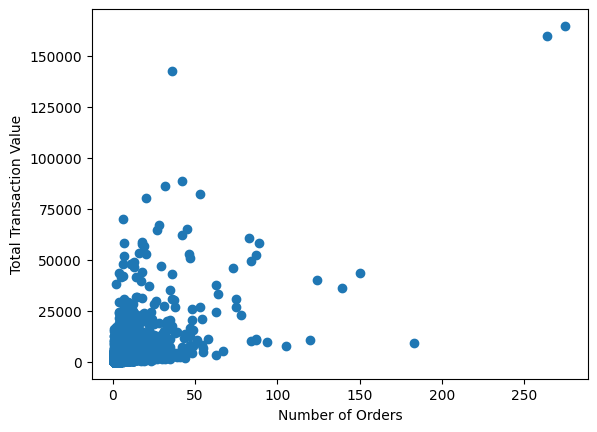

In [16]:
plt.scatter(num_merchants_orders_by_user.num_orders, num_merchants_orders_by_user.total_transaction_value)
plt.xlabel('Number of Orders')
plt.ylabel('Total Transaction Value')
plt.show()

In [17]:
num_merchants_orders_by_user.corr() # the higher the number of orders, the higher the spent

,user_id,num_merchant,num_orders,total_transaction_value
user_id,1.000000,0.025503,0.003450,0.002725
num_merchant,0.025503,1.000000,0.231905,0.176495
num_orders,0.003450,0.231905,1.000000,0.634776
total_transaction_value,0.002725,0.176495,0.634776,1.000000


In [18]:
# users that have more than 1 merchant id have more than 1 payment id as well
df[df.user_id.isin(merchants_per_user[merchants_per_user.merchant_id > 1].user_id)].groupby(['user_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False)

,user_id,payment_id
117,11031911,275
277,11060763,183
468,11092434,150
103,11029550,124
80,11025901,105
...,...,...
170,11043981,2
161,11042407,2
360,11075066,2
361,11075525,2


In [19]:
# do we have users that bought twice or more from the same merchant?
df.groupby(['user_id','merchant_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False) #yes

,user_id,merchant_id,payment_id
10957,11062232,160,264
4806,11031911,602,264
10644,11060763,288,182
16666,11092434,602,146
3175,11023684,160,139
...,...,...,...
6935,11042262,602,1
6936,11042268,160,1
6937,11042273,265,1
6938,11042277,470,1


In [20]:
# for the same user, can we have multiple merchants for the same payment id?
df.groupby(['user_id', 'payment_id'], as_index=False)['merchant_id'].nunique()['merchant_id'].unique() # no, each payment_id is linked to to 1 merchant_id and 1 user

array([1])

so the hierarchy is: you have multiple users --> each user can buy from multiple merchants --> from each merchant a user can done multiple orders(payments).

In [21]:
# how many users do we have per merchant?
num_users_per_merchant = df.groupby(['merchant_id'], as_index=False)['user_id'].nunique()
num_users_per_merchant

,merchant_id,user_id
0,32,80
1,68,351
2,72,30
3,75,80
4,88,871
...,...,...
86,621,34
87,623,442
88,626,154
89,631,1


In [22]:
# Assuming `df` is your DataFrame
# Convert columns to datetime
df['payment_timestamp'] = pd.to_datetime(df['payment_timestamp'], format='%m/%d/%Y %H:%M')
df['first_approved_payment_timestamp'] = pd.to_datetime(df['first_approved_payment_timestamp'], format='%m/%d/%Y %H:%M')

# Analyze data period
first_date = df['payment_timestamp'].min()
last_date = df['payment_timestamp'].max()
print(f"Data period: {first_date} to {last_date}")

# Extract features
def extract_features(df, column):
    # df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month
    df[f'{column}_day'] = df[column].dt.day
    df[f'{column}_hour'] = df[column].dt.hour
    df[f'{column}_weekday'] = df[column].dt.day_name()
    df[f'{column}_is_weekend'] = df[column].dt.weekday.isin([5, 6]).astype(int)
    df[f'{column}_season'] = df[column].dt.month % 12 // 3
    df[f'{column}_time_range'] = pd.cut(
        df[column].dt.hour,
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        right=False
    )
    return df

df = extract_features(df, 'payment_timestamp')

# Compute time difference in days
df['time_diff_days'] = (df['payment_timestamp'] - df['first_approved_payment_timestamp']).dt.total_seconds() / (3600 * 24)


Data period: 2024-05-31 23:56:00 to 2024-10-28 11:47:00


In [23]:
# from this snapshot of user 11008761 i understand the user journey
df[(df.user_id == 11008761)]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,state,device_type,payment_timestamp_month,payment_timestamp_day,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days
0,66675334,11008761,210,2024-05-31 23:56:00,2024-05-31 23:56:00,109.86,credit_card,CAD,7.045880,1,...,NaN,pc,5,31,23,Friday,0,1,Evening,0.000000
9,66675675,11008761,210,2024-06-01 00:27:00,2024-05-31 23:56:00,109.86,credit_card,CAD,1.114166,2,...,NaN,pc,6,1,0,Saturday,1,2,Night,0.021528
49,66677571,11008761,210,2024-06-01 03:55:00,2024-05-31 23:56:00,87.89,credit_card,CAD,1.383882,3,...,NaN,pc,6,1,3,Saturday,1,2,Night,0.165972
56,66677971,11008761,210,2024-06-01 04:45:00,2024-05-31 23:56:00,54.93,credit_card,CAD,1.421333,4,...,NaN,pc,6,1,4,Saturday,1,2,Night,0.200694
232,66684319,11008761,210,2024-06-01 14:09:00,2024-05-31 23:56:00,73.25,credit_card,CAD,2.089430,5,...,NaN,pc,6,1,14,Saturday,1,2,Afternoon,0.592361
244,66684645,11008761,210,2024-06-01 14:29:00,2024-05-31 23:56:00,54.93,credit_card,CAD,1.139712,6,...,NaN,pc,6,1,14,Saturday,1,2,Afternoon,0.606250
296,66686087,11008761,210,2024-06-01 15:58:00,2024-05-31 23:56:00,73.25,credit_card,CAD,1.109149,7,...,NaN,pc,6,1,15,Saturday,1,2,Afternoon,0.668056
11593,66967019,11008761,210,2024-06-13 18:43:00,2024-05-31 23:56:00,94.57,credit_card,CAD,2.575146,8,...,NaN,mobile,6,13,18,Thursday,0,2,Evening,12.782639


example of user journey: a user did a first payment on 31.5.24. then they did 6 more payments on the following day and after 2 weeks on the 13.6.24 they did another payment. the sum of the total_amount_usd is equal to the 8th total_approved_amount_usd_per_user 658.54.

In [24]:
# do we have merchants that have a higher/lower total_amount_usd
avg_amount_by_merchant = df.groupby(['merchant_id'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])
avg_amount_by_merchant[avg_amount_by_merchant.total_num_users >= 375].sort_values(by=['avg_amount_usd'], ascending=False) #min sample size for statistically significant inference

,merchant_id,avg_amount_usd,total_num_users,total_num_orders
4,88,554.174564,871,2167
55,432,538.681649,441,867
80,602,519.610884,1305,3427
28,265,510.819229,490,1063
19,210,396.377249,487,1076
75,591,365.559382,592,1263
31,288,257.759991,4470,10424
9,160,251.440144,3045,7731
87,623,200.827342,442,952


In [25]:
# do we have payment instruments that have a higher/lower total_amount_usd
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,payment_instrument,avg_amount_usd,total_num_users,total_num_orders
2,google_pay,424.269472,161,436
1,credit_card,372.794623,16057,40859
3,NaN,192.638333,12,12
0,bank_transfer,50.653571,12,14


In [26]:
# do we have currencies that have a higher/lower total_amount_usd
df.groupby(['currency'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,currency,avg_amount_usd,total_num_users,total_num_orders
25,HKD,1016.712419,36,62
12,CHF,1010.561393,160,402
0,AED,903.703622,175,370
40,MXN,696.151596,44,94
43,NZD,691.488605,54,129
8,BMD,670.690000,2,3
31,JPY,628.695745,160,329
51,SGD,605.762646,228,514
17,CZK,571.129132,123,380
30,ISK,530.991875,6,16


In [27]:
# do we have countries that have a higher/lower total_amount_usd
df.groupby(['country'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,country,avg_amount_usd,total_num_users,total_num_orders
50,GG,8641.250000,1,1
126,TV,3875.530000,2,4
91,MT,2320.958333,14,36
133,VI,1875.000000,2,6
9,AW,1006.250000,1,8
...,...,...,...,...
23,CG,47.275000,2,4
121,TG,41.230000,1,1
99,NP,39.750000,1,4
5,AO,36.580000,1,4


In [28]:
# do we have state that have a higher/lower total_amount_usd
df.groupby(['state'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,state,avg_amount_usd,total_num_users,total_num_orders
33,NM,2750.000000,1,2
49,WA,854.572344,28,64
28,NC,711.562778,113,378
41,RI,634.026667,5,9
43,SD,619.166667,6,12
42,SC,598.529559,76,204
8,DE,509.006250,21,56
38,PA,492.265565,111,372
27,MT,488.414286,11,21
35,OH,466.026430,122,465


In [29]:
# do we have device that have a higher/lower total_amount_usd
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,device_type,avg_amount_usd,total_num_users,total_num_orders
3,pc,523.294786,2862,6145
0,mobile,347.262139,13447,34780
4,tablet,339.253913,70,115
1,no_data,318.706931,106,202
2,other,311.783433,29,67
5,NaN,192.638333,12,12


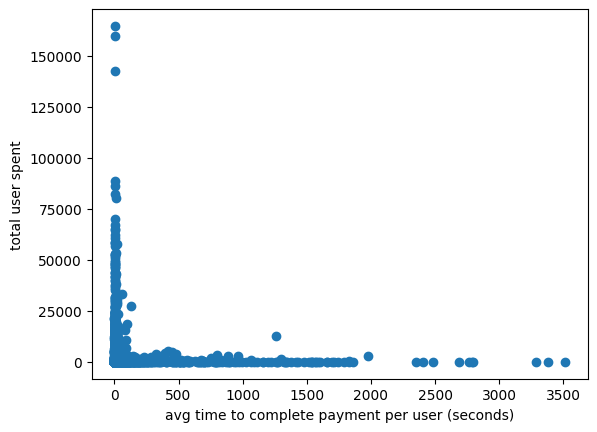

In [30]:
# does total spent decrease with time to complete payment?

amount_time_to_payment = df.groupby(['user_id'], as_index=False).agg(total_user_spent=('total_amount_usd','sum'), avg_time_to_complete_payment=('time_to_complete_payment','mean'))
plt.scatter(amount_time_to_payment.avg_time_to_complete_payment, amount_time_to_payment.total_user_spent)
plt.xlabel('avg time to complete payment per user (seconds)')
plt.ylabel('total user spent')
plt.show()

In [31]:
amount_time_to_payment.corr() # there is a slight negative correlation but not that strong -0.011307

,user_id,total_user_spent,avg_time_to_complete_payment
user_id,1.000000,0.002725,0.011664
total_user_spent,0.002725,1.000000,-0.011307
avg_time_to_complete_payment,0.011664,-0.011307,1.000000


In [32]:
# do we have merchants that have a higher/lower time_to_complete_payment
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,merchant_id,avg_time_to_complete_payment,total_num_users,total_num_orders
84,616,55.424567,30,43
73,582,48.777764,4,6
35,305,43.586637,2,4
17,201,38.006810,25,54
10,171,37.052898,6,7
...,...,...,...,...
42,346,2.376515,2,2
63,508,1.954826,1,1
79,599,1.822290,1,6
15,196,1.770718,1,3


In [33]:
# do we have payment instruments that have a higher/lower time_to_complete_payment
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,payment_instrument,avg_time_to_complete_payment,total_num_users,total_num_orders
2,google_pay,18.050337,161,436
1,credit_card,11.095096,16057,40859
3,NaN,8.756710,12,12
0,bank_transfer,7.519238,12,14


In [34]:
# do we have currencies that have a higher/lower time_to_complete_payment
df.groupby(['currency'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,currency,avg_time_to_complete_payment,total_num_users,total_num_orders
27,IDR,176.951260,6,7
2,AMD,78.165338,58,96
40,MXN,74.906082,44,94
25,HKD,67.760856,36,62
28,ILS,45.395084,62,176
33,KWD,40.738420,22,29
41,MYR,35.354414,48,94
49,RSD,34.568186,60,116
55,UAH,30.679493,97,131
53,TWD,29.773114,51,140


In [35]:
# do we have country that have a higher/lower time_to_complete_payment
df.groupby(['country'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,country,avg_time_to_complete_payment,total_num_users,total_num_orders
35,DM,251.276496,1,1
78,LR,188.804717,3,3
2,AG,115.939442,1,2
93,MX,104.469477,46,100
11,AZ,104.171918,15,27
...,...,...,...,...
99,NP,2.175954,1,4
10,AX,2.129569,1,2
89,MN,2.033728,1,3
15,BH,1.888225,5,52


In [36]:
# do we have state that have a higher/lower time_to_complete_payment
df.groupby(['state'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,state,avg_time_to_complete_payment,total_num_users,total_num_orders
48,VT,52.609110,6,10
8,DE,16.867928,21,56
49,WA,14.433155,28,64
53,NaN,14.040765,12635,28943
30,NE,13.343137,24,56
7,DC,11.563738,25,62
18,LA,10.044098,1,1
46,UT,9.146686,68,304
9,FL,8.367473,31,62
6,CT,7.572223,124,312


In [37]:
# do we have device that have a higher/lower time_to_complete_payment
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,device_type,avg_time_to_complete_payment,total_num_users,total_num_orders
4,tablet,12.608673,70,115
0,mobile,11.311789,13447,34780
3,pc,10.577383,2862,6145
5,NaN,8.756710,12,12
1,no_data,5.812254,106,202
2,other,3.934709,29,67


tablet is the device type with highest average time to complete payment.

In [38]:
# do we have merchants that have a higher/lower time_diff_days
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,merchant_id,avg_time_diff_days,total_num_users,total_num_orders
56,455,39.734132,6,20
25,243,33.034130,247,1274
52,417,30.319476,109,282
85,618,30.200468,203,792
39,320,28.945166,65,252
...,...,...,...,...
61,495,0.000000,1,1
78,597,0.000000,1,1
63,508,0.000000,1,1
65,519,0.000000,1,1


In [39]:
# do we have payment instruments that have a higher/lower time_diff_days
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,payment_instrument,avg_time_diff_days,total_num_users,total_num_orders
1,credit_card,15.663070,16057,40859
2,google_pay,13.971120,161,436
3,NaN,1.312326,12,12
0,bank_transfer,0.342510,12,14


In [40]:
# do we have currencies that have a higher/lower time_diff_days
df.groupby(['currency'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,currency,avg_time_diff_days,total_num_users,total_num_orders
7,BHD,91.372873,3,48
14,CNY,35.818194,1,5
56,USD,22.801255,4609,14007
35,MAD,21.978540,10,51
53,TWD,18.012966,51,140
31,JPY,15.657166,160,329
21,GBP,15.492919,2038,5289
12,CHF,14.671305,160,402
28,ILS,14.090195,62,176
40,MXN,13.487566,44,94


In [41]:
# do we have country that have a higher/lower time_diff_days
df.groupby(['country'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,country,avg_time_diff_days,total_num_users,total_num_orders
15,BH,88.103592,5,52
47,GD,57.697933,1,43
25,CI,41.379178,33,354
82,MA,40.400621,16,94
5,AO,39.141667,1,4
...,...,...,...,...
87,MG,0.000000,1,1
121,TG,0.000000,1,1
37,DZ,0.000000,2,2
35,DM,0.000000,1,1


In [42]:
# do we have state that have a higher/lower time_diff_days
df.groupby(['state'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,state,avg_time_diff_days,total_num_users,total_num_orders
37,OR,40.591672,45,277
23,MI,36.000552,108,557
46,UT,33.089988,68,304
50,WI,31.095341,40,168
4,CA,29.978082,461,1790
45,TX,28.425812,370,1449
0,AL,27.904202,65,357
47,VA,27.325242,100,547
12,IA,26.280690,24,62
28,NC,25.894626,113,378


In [43]:
# do we have device that have a higher/lower time_diff_days
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,device_type,avg_time_diff_days,total_num_users,total_num_orders
2,other,27.003141,29,67
0,mobile,15.807555,13447,34780
3,pc,14.931293,2862,6145
1,no_data,9.471119,106,202
4,tablet,7.057814,70,115
5,NaN,1.312326,12,12


In [44]:
# do we have merchants that have a higher/lower total_num_orders
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,merchant_id,total_num_users,total_num_orders
31,288,4470,10424
9,160,3045,7731
80,602,1305,3427
4,88,871,2167
25,243,247,1274
...,...,...,...
34,303,1,1
65,519,1,1
40,327,1,1
68,557,1,1


In [45]:
# do we have payment instruments that have a higher/lower total_num_orders
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,payment_instrument,total_num_users,total_num_orders
1,credit_card,16057,40859
2,google_pay,161,436
0,bank_transfer,12,14
3,NaN,12,12


In [46]:
# do we have currencies that have a higher/lower total_num_orders
df.groupby(['currency'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,currency,total_num_users,total_num_orders
56,USD,4609,14007
20,EUR,5824,12616
21,GBP,2038,5289
11,CAD,637,1384
4,AUD,372,919
46,PLN,296,641
42,NOK,274,593
51,SGD,228,514
48,RON,256,514
12,CHF,160,402


In [47]:
# do we have country that have a higher/lower total_num_orders
df.groupby(['country'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,country,total_num_users,total_num_orders
129,US,2980,10939
46,GB,1757,5011
33,DE,1202,2665
45,FR,1161,2120
67,IT,889,1820
...,...,...,...
57,GU,1,1
35,DM,1,1
87,MG,1,1
54,GQ,1,1


In [48]:
# do we have state that have a higher/lower total_num_orders
df.groupby(['state'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,state,total_num_users,total_num_orders
53,NaN,12635,28943
4,CA,461,1790
45,TX,370,1449
20,MD,232,690
23,MI,108,557
47,VA,100,547
14,IL,140,545
10,GA,183,486
35,OH,122,465
28,NC,113,378


In [49]:
# do we have device that have a higher/lower total_num_orders
df.groupby(['device_type'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,device_type,total_num_users,total_num_orders
0,mobile,13447,34780
3,pc,2862,6145
1,no_data,106,202
4,tablet,70,115
2,other,29,67
5,NaN,12,12


- Bucket users by loyalty level - how loyal they are for each merchant, how many transaction, or avg transaction x months. Action: Provide a loyalty tier upgrade, VIP support, or targeted marketing to cement loyalty.

In [50]:
df.groupby(['user_id','merchant_id','payment_timestamp_month'], as_index=False)['payment_id'].nunique()

,user_id,merchant_id,payment_timestamp_month,payment_id
0,11008761,210,5,1
1,11008761,210,6,7
2,11008762,117,6,1
3,11008768,248,6,1
4,11008770,160,7,1
...,...,...,...,...
19943,11092755,160,6,1
19944,11092757,602,6,1
19945,11092767,210,6,1
19946,11092771,459,6,1


In [51]:
# Step 1: Frequency of interaction
loyalty_frequency = df.groupby(['user_id', 'merchant_id'], as_index=False)['payment_timestamp_month'].nunique()
loyalty_frequency.rename(columns={'payment_timestamp_month': 'num_active_months'}, inplace=True)

# Step 2: Recency
df['last_payment_month'] = df.groupby(['user_id', 'merchant_id'])['payment_timestamp_month'].transform('max')
most_recent_month = df['payment_timestamp_month'].max()
df['recency'] = most_recent_month - df['last_payment_month']

# Step 3: Average transactions per month
avg_tx_per_month = df.groupby(['user_id', 'merchant_id'], as_index=False)['payment_id'].nunique()
avg_tx_per_month = avg_tx_per_month.groupby(['user_id', 'merchant_id'], as_index=False)['payment_id'].mean()
avg_tx_per_month.rename(columns={'payment_id': 'avg_tx_per_month'}, inplace=True)

# Step 4: Join metrics to compute loyalty score
loyalty_df = loyalty_frequency.merge(avg_tx_per_month, on=['user_id', 'merchant_id'])
loyalty_df = loyalty_df.merge(df[['user_id', 'merchant_id', 'recency']].drop_duplicates(), on=['user_id', 'merchant_id'])

# Normalize and compute loyalty score
loyalty_df['loyalty_score'] = (
    0.4 * (loyalty_df['num_active_months'] / loyalty_df['num_active_months'].max()) +
    0.3 * (1 - (loyalty_df['recency'] / loyalty_df['recency'].max())) +
    0.3 * (loyalty_df['avg_tx_per_month'] / loyalty_df['avg_tx_per_month'].max())
)


In [52]:
loyalty_df

,user_id,merchant_id,num_active_months,avg_tx_per_month,recency,loyalty_score
0,11008761,210,2,8.0,4,0.169091
1,11008762,117,1,1.0,4,0.081136
2,11008768,248,1,1.0,4,0.081136
3,11008770,160,1,1.0,3,0.156136
4,11008770,618,1,1.0,4,0.081136
...,...,...,...,...,...,...
16714,11092755,160,1,1.0,4,0.081136
16715,11092757,602,1,1.0,4,0.081136
16716,11092767,210,1,1.0,4,0.081136
16717,11092771,459,1,1.0,4,0.081136


users that bought from merchants 602, 160 are the most loyal one in terms of:
- number of months they've been active
- their last payment has been very recently
- they spend a higher average transaction value.

In [53]:
df.groupby(['payment_instrument', 'device_type','merchant_id','currency','country','state'], as_index=False).agg(num_users=('user_id','nunique'),num_orders=('payment_id','nunique'),total_amount=('total_amount_usd','sum')).sort_values(by=['total_amount'], ascending=[False])

,payment_instrument,device_type,merchant_id,currency,country,state,num_users,num_orders,total_amount
724,credit_card,mobile,602,USD,US,CA,14,266,149404.44
850,credit_card,mobile,626,USD,US,NC,8,60,130952.00
219,credit_card,mobile,160,USD,US,TX,97,431,109193.90
368,credit_card,mobile,243,USD,US,TX,13,165,99129.39
489,credit_card,mobile,288,USD,US,VA,12,129,95736.00
...,...,...,...,...,...,...,...,...,...
1091,credit_card,pc,288,USD,US,GA,1,1,30.00
693,credit_card,mobile,595,USD,US,NC,1,1,30.00
169,credit_card,mobile,160,INR,IN,UT,1,1,30.00
176,credit_card,mobile,160,USD,ES,CT,1,1,30.00


the most lucrative segment of users are users who pay with credit card from mobile, for merchant 602 in USD, in california. while the most recurring ones are users that pay with credit card, through mobile, to merchant_id 160 in USD in california.

In [54]:
# how many times does a user pay per month? we want to look at the monthly payment rate

num_payments_per_user_per_month = df.groupby(['user_id'], as_index=False).agg(num_active_months=('payment_timestamp_month','nunique'),num_orders=('payment_id','nunique'))
num_payments_per_user_per_month['monthly_payment_rate'] = num_payments_per_user_per_month['num_orders']/num_payments_per_user_per_month['num_active_months']
num_payments_per_user_per_month.sort_values(by=['monthly_payment_rate'], ascending=[False])

,user_id,num_active_months,num_orders,monthly_payment_rate
4681,11031911,5,275,55.0
10652,11062232,5,264,52.8
3583,11025901,2,105,52.5
4099,11028635,2,75,37.5
10346,11060763,5,183,36.6
...,...,...,...,...
6639,11041759,1,1,1.0
6640,11041764,1,1,1.0
6641,11041771,1,1,1.0
6642,11041774,1,1,1.0


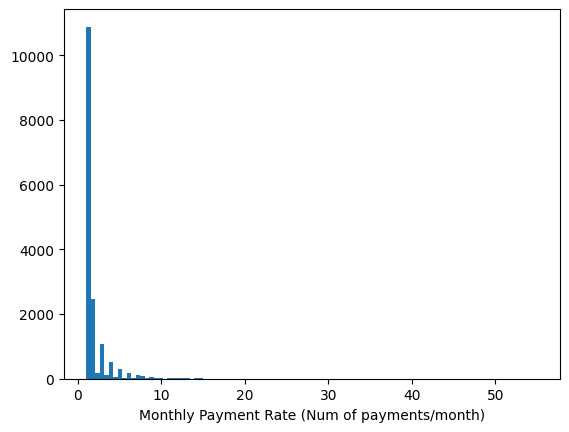

In [55]:
# let's see the distribution of the monthly payment rate: very skewed
plt.hist(num_payments_per_user_per_month['monthly_payment_rate'], bins=100)
plt.xlabel('Monthly Payment Rate (Num of payments/month)')
plt.show()

from the histogram we can see that the right tail of high-rate spenders starts around an average of 10 payments/month. So that's the threshold that I'm gonna use to define high rate spenders.

In [56]:
# let's see if these high-rate spenders have some particular characteristics

high_rate_spenders = df[df.user_id.isin(num_payments_per_user_per_month[num_payments_per_user_per_month.monthly_payment_rate > 10].user_id)]

In [57]:
# what's the average total amount usd per user
high_rate_spenders.groupby(['user_id'])['total_amount_usd'].mean().describe()

count     149.000000
mean      525.254845
std       619.440479
min        36.454545
25%       120.818182
50%       364.285714
75%       655.952360
max      4363.636364
Name: total_amount_usd, dtype: float64

on average these users spend 525 usd.

In [58]:
# let's see what's the most common payment instrument: credit card
high_rate_spenders.groupby(['payment_instrument'])['user_id'].nunique()

payment_instrument
credit_card    147
google_pay       3
Name: user_id, dtype: int64

In [59]:
# let's see what's the most common currency
high_rate_spenders.groupby(['currency'], as_index=False)['user_id'].nunique().sort_values(by=['user_id'], ascending=[False]).head(3)

,currency,user_id
21,USD,73
7,EUR,41
8,GBP,27


the top 3 most common currencies of high-rate spenders are USD, EUR and GBP.

In [60]:
# what's the average time to complete payment (in seconds)?
high_rate_spenders.groupby(['user_id'])['time_to_complete_payment'].mean().describe()

count    149.000000
mean       4.636623
std       11.672658
min        0.667492
25%        1.524497
50%        2.148510
75%        3.168844
max       95.253272
Name: time_to_complete_payment, dtype: float64

the average time to complete a payment for high rate spenders is 4 seconds almost 5.

In [61]:
# what's the most frequent country of high-rate spenders
high_rate_spenders.groupby(['country'], as_index=False)['user_id'].nunique().sort_values(by=['user_id'], ascending=[False]).head(3)

,country,user_id
35,US,62
14,GB,20
26,NL,6


US and GB are the top 2 countries from which high-rate spenders come from

In [62]:
# what's the most frequent mobile device of high-rate spenders: mobile
high_rate_spenders.groupby(['device_type'], as_index=False)['user_id'].nunique()

,device_type,user_id
0,mobile,142
1,pc,24


In [63]:
# these are the countries for which state is available
df[~df.state.isna()].country.drop_duplicates()

1        US
63       AE
80       CL
95       ES
124      NL
131      BE
147      FR
539      NI
632      JP
644      PL
725      ID
726      AU
836      GB
1216     RO
1563     PT
1622     CO
2340     DE
2365     HU
2707     BR
2902     GT
3322     MD
3503     MU
3535     LA
4807     IL
5091     IN
5201     LT
6029     UY
6088     LR
6253     BW
6871     UA
8960     OM
9113     IT
10006    GY
10273    CH
12304    KZ
15137    KW
18458    AT
20074    MX
21320    CZ
21375    AZ
22147    GR
33617    LV
34018    SE
40675    EE
Name: country, dtype: object

In [64]:
# we say high-rate spenders. now let's see high-value spenders

tot_value_per_user_per_month = df.groupby(['user_id'], as_index=False).agg(num_active_months=('payment_timestamp_month','nunique'),num_orders=('payment_id','nunique'), tot_spent=('total_amount_usd','sum'))
tot_value_per_user_per_month['monthly_payment_value'] = tot_value_per_user_per_month['tot_spent']/tot_value_per_user_per_month['num_active_months']
tot_value_per_user_per_month.sort_values(by=['monthly_payment_value'], ascending=[False])

,user_id,num_active_months,num_orders,tot_spent,monthly_payment_value
2753,11021938,1,11,48000.00,48000.00
5563,11036484,1,29,46840.00,46840.00
8240,11049809,1,13,46333.99,46333.99
10128,11059604,1,17,39542.49,39542.49
12716,11074149,1,2,38426.78,38426.78
...,...,...,...,...,...
9249,11055472,1,1,29.91,29.91
8443,11051061,1,1,29.88,29.88
4334,11029935,1,1,29.72,29.72
5875,11038177,1,1,29.58,29.58


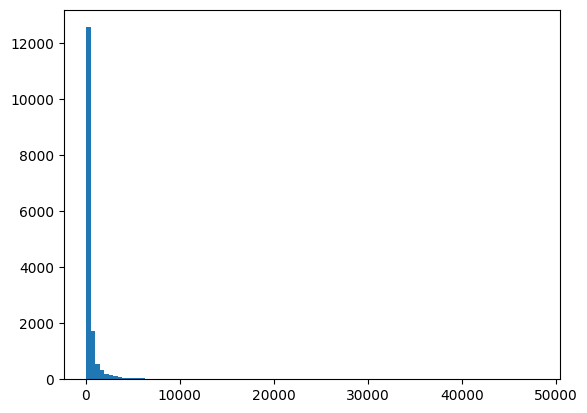

In [65]:
plt.hist(tot_value_per_user_per_month.monthly_payment_value, bins=100)
plt.show()

In [66]:
tot_value_per_user_per_month['monthly_payment_value'].describe() # the average spent for high-value spenders is 633

count    16208.000000
mean       633.545448
std       1977.299251
min         29.200000
25%         64.280000
50%        150.250000
75%        450.000000
max      48000.000000
Name: monthly_payment_value, dtype: float64

In [67]:
# let's look at high spenders as those users that spend more than an average of 10k USD/month (right tail)

# what's the average number of orders?
tot_value_per_user_per_month[tot_value_per_user_per_month['monthly_payment_value'] > 10000].num_orders.mean()

19.225352112676056

users that spend more than 10 times a month spend on averag 525usd, while users that on average spend 633usd a month - they do it in 19 payments on average.


In [68]:
high_value_users = df[df.user_id.isin(tot_value_per_user_per_month[tot_value_per_user_per_month['monthly_payment_value'] > 10000].user_id)]

In [69]:
high_value_users.payment_instrument.value_counts()

payment_instrument
credit_card    2729
google_pay        1
Name: count, dtype: int64

In [70]:
high_value_users.currency.value_counts()

currency
USD    1297
EUR     695
GBP     310
CAD      82
CHF      70
AED      60
PLN      36
AUD      33
CZK      28
SGD      26
NZD      17
MXN      17
BRL      15
ILS       9
CLP       9
NOK       9
JPY       6
GEL       6
DKK       3
HKD       2
Name: count, dtype: int64

In [71]:
high_value_users.time_to_complete_payment.mean()

4.332079050549451

In [72]:
high_value_users.country.value_counts()

country
US    1232
GB     328
CI     264
CH     149
CA      98
NL      71
DE      69
IT      58
AE      58
AU      42
SK      42
FR      37
PL      32
SG      26
ES      23
MT      20
CZ      20
NZ      17
MX      17
PT      17
BE      16
AT      15
BR      15
CL      10
IL       9
NO       9
DK       8
GE       6
SI       5
VI       4
LT       4
CY       4
JP       2
HK       2
RO       1
Name: count, dtype: int64

In [73]:
high_value_users.device_type.value_counts()

device_type
mobile    2163
pc         561
tablet       6
Name: count, dtype: int64

In [74]:
df.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_month,payment_timestamp_day,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency
0,66675334,11008761,210,2024-05-31 23:56:00,2024-05-31 23:56:00,109.86,credit_card,CAD,7.045880,1,...,5,31,23,Friday,0,1,Evening,0.0,6,4
1,66675371,11008762,117,2024-06-01 00:00:00,2024-06-01 00:00:00,108.71,credit_card,USD,3.236956,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
2,66675434,11008768,248,2024-06-01 00:07:00,2024-06-01 00:07:00,150.00,credit_card,USD,3.431595,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
3,66675492,11008775,288,2024-06-01 00:12:00,2024-06-01 00:12:00,30.00,credit_card,USD,1.600267,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
4,66675558,11008784,160,2024-06-01 00:18:00,2024-06-01 00:18:00,41.42,credit_card,EUR,2.335492,1,...,6,1,0,Saturday,1,2,Night,0.0,7,3


Text(0, 0.5, 'Total Amount USD')

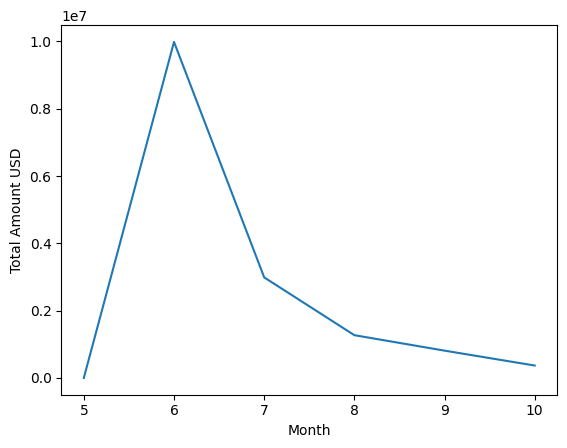

In [75]:
# overall spending trend

plt.plot(df.groupby(['payment_timestamp_month'])['total_amount_usd'].sum())
plt.xlabel('Month')
plt.ylabel('Total Amount USD')

overall the highest spending month among all users is june.

In [76]:
# let's identify the trend per user
pivoted_df = df.pivot_table(
    index='user_id',                    # Rows (unique user IDs)
    columns='payment_timestamp_month',  # Columns (months)
    values='total_amount_usd',          # Values to fill
    aggfunc='sum',                      # Aggregate function (sum in case of duplicates)
    fill_value=0                        # Fill missing values with 0
)

# Reset column names for better readability
pivoted_df.columns = [f'month_{int(col)}' for col in pivoted_df.columns]

# Reset the index if needed
pivoted_df.reset_index(inplace=True)

pivoted_df


,user_id,month_5,month_6,month_7,month_8,month_9,month_10
0,11008761,109.86,548.68,0.0,0.0,0.0,0.0
1,11008762,0.00,108.71,0.0,0.0,0.0,0.0
2,11008768,0.00,150.00,0.0,0.0,0.0,0.0
3,11008770,0.00,275.00,65.0,0.0,0.0,0.0
4,11008774,0.00,3000.00,1000.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
16203,11092755,0.00,100.00,0.0,0.0,0.0,0.0
16204,11092757,0.00,3000.00,0.0,0.0,0.0,0.0
16205,11092767,0.00,210.00,0.0,0.0,0.0,0.0
16206,11092771,0.00,213.35,0.0,0.0,0.0,0.0


In [77]:
# Calculate month-to-month differences for each user
monthly_diff = pivoted_df.set_index('user_id').diff(axis=1)

In [78]:
monthly_diff

,month_5,month_6,month_7,month_8,month_9,month_10
user_id,,,,,,
11008761,NaN,438.82,-548.68,0.0,0.0,0.0
11008762,NaN,108.71,-108.71,0.0,0.0,0.0
11008768,NaN,150.00,-150.00,0.0,0.0,0.0
11008770,NaN,275.00,-210.00,-65.0,0.0,0.0
11008774,NaN,3000.00,-2000.00,-1000.0,0.0,0.0
...,...,...,...,...,...,...
11092755,NaN,100.00,-100.00,0.0,0.0,0.0
11092757,NaN,3000.00,-3000.00,0.0,0.0,0.0
11092767,NaN,210.00,-210.00,0.0,0.0,0.0


In [79]:
# Check if the differences are positive (spending increases)
increasing_users = monthly_diff.apply(lambda x: all(x > 0), axis=1)

In [80]:
increasing_users.drop_duplicates() # there is no user whose spending trend is constantly increasing

user_id
11008761    False
dtype: bool

I look at payment_instrument, country, currency, device_type. the questions that I am trying to answer:
- for which countries switching to local currency would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
- for which countries switching to a certain payment method would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
- for which countries switching to a certain device type would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

In [81]:
# Function to get the official currency for a country
def get_official_currency(country_code):
    try:
        # Retrieve country information using the alpha_2 code
        country = pycountry.countries.get(alpha_2=country_code)
        if country:
            # Retrieve the currency information for the country
            currency = pycountry.currencies.get(numeric=country.numeric)
            return currency.alpha_3 if currency else None
        return None
    except:
        return None

# Example: Add the official currency column for your DataFrame
df['official_currency'] = df['country'].apply(get_official_currency)

# Manual mapping of countries to their official currencies
missing_countries_to_currency = {
    'FR': 'EUR', 'AT': 'EUR', 'IT': 'EUR', 'DE': 'EUR', 'SI': 'EUR', 'NL': 'EUR',
    'TW': 'TWD', 'PT': 'EUR', 'ES': 'EUR', 'RO': 'RON', 'PL': 'PLN', 'CI': 'XOF',
    'UA': 'UAH', 'LT': 'EUR', 'GR': 'EUR', 'BE': 'EUR', 'RS': 'RSD', 'FI': 'EUR',
    'CY': 'EUR', 'BR': 'BRL', 'IE': 'EUR', 'SK': 'EUR', 'ME': 'EUR', 'EE': 'EUR',
    'LV': 'EUR', 'PR': 'USD', 'AG': 'XCD', 'GE': 'GEL', 'GF': 'EUR', 'GH': 'GHS',
    'AZ': 'AZN', 'ET': 'ETB', 'MT': 'EUR', 'NC': 'XPF', 'RE': 'EUR', 'EC': 'USD',
    'MQ': 'EUR', 'JE': 'GBP', 'LU': 'EUR', 'GP': 'EUR', 'CG': 'XAF', 'AD': 'EUR',
    'DM': 'XCD', 'PF': 'XPF', 'VI': 'USD', 'GD': 'XCD', 'TG': 'XOF', 'BJ': 'XOF',
    'GL': 'DKK', 'LI': 'CHF', 'CW': 'ANG', 'MG': 'MGA', 'FO': 'DKK', 'LC': 'XCD',
    'GQ': 'XAF', 'AO': 'AOA', 'GG': 'GBP', 'BA': 'BAM', 'CK': 'NZD', 'TC': 'USD',
    'MC': 'EUR', 'AX': 'EUR', 'VG': 'USD', 'MF': 'EUR', 'TJ': 'TJS', 'GU': 'USD',
    'BQ': 'USD', 'TV': 'AUD'
}

# Fill missing official currencies
df['official_currency'] = df['official_currency'].fillna(df['country'].map(missing_countries_to_currency))


In [82]:
df['is_paying_in_local_currency'] = np.where(df['currency']==df['official_currency'],1,0)

In [83]:
# for which countries switching to local currency would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
local_vs_nonlocal = df.groupby(['country', 'is_paying_in_local_currency']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for local and non-local currency
local_vs_nonlocal['spending_per_user'] = local_vs_nonlocal['tot_spent'] / local_vs_nonlocal['tot_num_users']
local_vs_nonlocal['orders_per_user'] = local_vs_nonlocal['tot_num_orders'] / local_vs_nonlocal['tot_num_users']

# Separate local and non-local currencies
local = local_vs_nonlocal[local_vs_nonlocal['is_paying_in_local_currency'] == 1]
non_local = local_vs_nonlocal[local_vs_nonlocal['is_paying_in_local_currency'] == 0]

# Merge local and non-local metrics for comparison
comparison = local.merge(non_local, on='country', suffixes=('_local', '_non_local'))

# Identify countries with high potential for switching to local currency
opportunity_countries = comparison[
    (comparison['spending_per_user_non_local'] < comparison['spending_per_user_local']) &
    (comparison['orders_per_user_non_local'] < comparison['orders_per_user_local']) &
    (comparison['avg_time_to_complete_payment_non_local'] > comparison['avg_time_to_complete_payment_local'])
]

# Calculate percentage changes for per-user metrics
opportunity_countries['spending_increase_pct'] = (
    (opportunity_countries['spending_per_user_local'] - opportunity_countries['spending_per_user_non_local']) /
    opportunity_countries['spending_per_user_non_local']
) * 100

opportunity_countries['orders_increase_pct'] = (
    (opportunity_countries['orders_per_user_local'] - opportunity_countries['orders_per_user_non_local']) /
    opportunity_countries['orders_per_user_non_local']
) * 100

opportunity_countries['time_to_payment_decrease_pct'] = (
    (opportunity_countries['avg_time_to_complete_payment_non_local'] - opportunity_countries['avg_time_to_complete_payment_local']) /
    opportunity_countries['avg_time_to_complete_payment_non_local']
) * 100

# Display the results
opportunity_countries[['country', 'spending_increase_pct', 'orders_increase_pct', 'time_to_payment_decrease_pct']].sort_values(by=['spending_increase_pct'], ascending=[False]).head(3)


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/452105547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opportunity_countries['spending_increase_pct'] = (
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/452105547.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opportunity_countries['orders_increase_pct'] = (
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/452105547.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,country,spending_increase_pct,orders_increase_pct,time_to_payment_decrease_pct
55,MT,8172.391162,190.909091,69.753701
8,BH,1730.429079,1100.000000,49.893491
67,RE,351.300000,50.000000,29.274080


We found 16 countries that if we switch to local currency fully we would have an increase in spending per user, in orders per user and a decrease in time to payment. I would give priority to countries like Bahrain, Mexico and Reunion where the percentage increase in spend per user from switching to local currency is the highest.


In [84]:
#for which countries switching to a certain payment method would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

# Step 1: Identify users with more than 1 payment instrument
users_multiple_payment_instruments = df.groupby(['country', 'user_id'])['payment_instrument'].nunique().reset_index()
users_multiple_payment_instruments = users_multiple_payment_instruments[users_multiple_payment_instruments['payment_instrument'] > 1]

# Step 2: Filter the original DataFrame to include only these users
df_filtered = df[df['user_id'].isin(users_multiple_payment_instruments['user_id'])]

# Step 3: Recalculate metrics for these filtered users
local_vs_nonlocal_payment_filtered = df_filtered.groupby(['country', 'payment_instrument']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for each payment method
local_vs_nonlocal_payment_filtered['spending_per_user'] = (
    local_vs_nonlocal_payment_filtered['tot_spent'] / local_vs_nonlocal_payment_filtered['tot_num_users']
)
local_vs_nonlocal_payment_filtered['orders_per_user'] = (
    local_vs_nonlocal_payment_filtered['tot_num_orders'] / local_vs_nonlocal_payment_filtered['tot_num_users']
)

local_vs_nonlocal_payment_filtered[['country', 'payment_instrument','avg_time_to_complete_payment', 'spending_per_user','orders_per_user']]


,country,payment_instrument,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AT,credit_card,1.943852,546.330000,2.500000
1,AT,google_pay,5.732765,410.785000,1.000000
2,DE,credit_card,4.097874,1955.363333,5.000000
3,DE,google_pay,15.215767,2044.903333,3.666667
4,ES,credit_card,6.358709,1013.053333,3.000000
5,ES,google_pay,7.772085,728.853333,2.333333
6,FR,credit_card,4.965903,437.351111,1.777778
7,FR,google_pay,13.549358,1335.081111,3.333333
8,GB,credit_card,4.021262,2831.510000,12.000000
9,GB,google_pay,8.248953,94.065000,1.000000


for each country, we want to switch to the payment instrument that has a lower time to complete payment, a higher spending per user and a higher number of orders per user:
- AT: Austria: google pay --> credit card
- DE: Germany: google pay --> credit card
- ES: Spain: google pay --> credit card
- FR: France: credit card --> google pay (even if time to payment is 2 times higher, spending per user is 3 times higher and number of orders per user is 2 times higher in google pay)
- GB: United Kingdom (Great Britain) google pay --> credit card
- HU: Hungary: google pay --> credit card
- IT: Italy: credit card --> google pay
- NL: Netherlands: google pay --> credit card
- PL: Poland: credit card --> google pay

In [85]:
# Step 1: Separate data for each payment instrument
credit_card_data = local_vs_nonlocal_payment_filtered[local_vs_nonlocal_payment_filtered['payment_instrument'] == 'credit_card']
google_pay_data = local_vs_nonlocal_payment_filtered[local_vs_nonlocal_payment_filtered['payment_instrument'] == 'google_pay']

# Step 2: Merge the two datasets by country
merged_data = credit_card_data.merge(
    google_pay_data,
    on='country',
    suffixes=('_credit_card', '_google_pay')
)

# Step 3: Define countries for specific switches
switch_to_credit_card = ['AT', 'DE', 'ES', 'GB', 'HU', 'NL']  # Countries switching Google Pay --> Credit Card
switch_to_google_pay = ['FR', 'IT', 'PL']  # Countries switching Credit Card --> Google Pay

# Step 4: Calculate percentage changes for each country
merged_data['spending_change_pct'] = merged_data.apply(
    lambda row: ((row['spending_per_user_credit_card'] - row['spending_per_user_google_pay']) /
                 row['spending_per_user_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['spending_per_user_google_pay'] - row['spending_per_user_credit_card']) /
          row['spending_per_user_credit_card'] * 100),
    axis=1
)

merged_data['orders_change_pct'] = merged_data.apply(
    lambda row: ((row['orders_per_user_credit_card'] - row['orders_per_user_google_pay']) /
                 row['orders_per_user_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['orders_per_user_google_pay'] - row['orders_per_user_credit_card']) /
          row['orders_per_user_credit_card'] * 100),
    axis=1
)

merged_data['time_change_pct'] = merged_data.apply(
    lambda row: ((row['avg_time_to_complete_payment_google_pay'] - row['avg_time_to_complete_payment_credit_card']) /
                 row['avg_time_to_complete_payment_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['avg_time_to_complete_payment_credit_card'] - row['avg_time_to_complete_payment_google_pay']) /
          row['avg_time_to_complete_payment_credit_card'] * 100),
    axis=1
)

# Step 5: Add a direction column
merged_data['direction'] = merged_data['country'].apply(
    lambda x: 'google_pay --> credit_card' if x in switch_to_credit_card else 'credit_card --> google_pay'
)

# Step 6: Select and display relevant columns
result = merged_data[['country', 'direction', 'spending_change_pct', 'orders_change_pct', 'time_change_pct']]
result


,country,direction,spending_change_pct,orders_change_pct,time_change_pct
0,AT,google_pay --> credit_card,32.996580,150.000000,66.092247
1,DE,google_pay --> credit_card,-4.378691,36.363636,73.068238
2,ES,google_pay --> credit_card,38.992756,28.571429,18.185295
3,FR,credit_card --> google_pay,205.265284,87.500000,-172.847844
4,GB,google_pay --> credit_card,2910.163185,1100.000000,51.251240
5,HU,google_pay --> credit_card,-14.561313,33.333333,-3.816850
6,IT,credit_card --> google_pay,788.369929,100.000000,69.596639
7,NL,google_pay --> credit_card,527.345999,218.181818,96.605214
8,PL,credit_card --> google_pay,933.728856,150.000000,61.016030


In [86]:
#for which countries switching to a certain device type would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

# Step 1: Identify users with more than 1 payment instrument
users_multiple_device = df.groupby(['country', 'user_id'])['device_type'].nunique().reset_index()
users_multiple_device = users_multiple_device[users_multiple_device['device_type'] > 1]


# Step 2: Filter the original DataFrame to include only these users
df_filtered = df[df['user_id'].isin(users_multiple_device['user_id'])]

# Step 3: Recalculate metrics for these filtered users
local_vs_nonlocal_device = df_filtered.groupby(['country', 'device_type']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for each payment method
local_vs_nonlocal_device['spending_per_user'] = (
    local_vs_nonlocal_device['tot_spent'] / local_vs_nonlocal_device['tot_num_users']
)
local_vs_nonlocal_device['orders_per_user'] = (
    local_vs_nonlocal_device['tot_num_orders'] / local_vs_nonlocal_device['tot_num_users']
)

local_vs_nonlocal_device[['country', 'device_type','avg_time_to_complete_payment', 'spending_per_user','orders_per_user']]


,country,device_type,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AE,mobile,2.939277,6806.365000,2.500000
1,AE,pc,17.798664,3115.373333,3.333333
2,AE,tablet,2.562771,1185.040000,4.000000
3,AT,mobile,69.973106,790.675000,3.333333
4,AT,no_data,5.958840,295.650000,1.000000
...,...,...,...,...,...
122,US,other,3.246808,2580.000000,8.000000
123,US,pc,2.413883,2742.672857,8.285714
124,US,tablet,6.544071,122.500000,3.000000
125,UY,mobile,2.775460,137.745000,1.000000


In [87]:
# Define the function to select the best device type for each country
def select_best_device(group):
    # Sort the group by spending, orders, and time
    sorted_group = group.sort_values(
        by=['spending_per_user', 'orders_per_user', 'avg_time_to_complete_payment'],
        ascending=[False, False, True]
    )
    return sorted_group.iloc[0]  # Return the top row after sorting

# Apply the selection logic to each group
best_device_per_country = (
    local_vs_nonlocal_device.groupby('country', group_keys=False)
    .apply(select_best_device)
    .reset_index(drop=True)
)

# Display the relevant columns
best_device_per_country = best_device_per_country[['country', 'device_type', 'avg_time_to_complete_payment', 'spending_per_user', 'orders_per_user']]
best_device_per_country


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/343285023.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(select_best_device)


,country,device_type,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AE,mobile,2.939277,6806.365000,2.500000
1,AT,mobile,69.973106,790.675000,3.333333
2,AU,mobile,22.482972,381.903333,2.333333
3,BE,mobile,3.533151,303.450000,2.000000
4,BS,pc,5.884061,65.750000,1.000000
5,CA,pc,4.285154,4252.001538,4.076923
6,CH,pc,4.444943,6643.620833,7.666667
7,CO,pc,3.017417,446.135000,3.000000
8,CR,pc,18.644589,51.030000,1.000000
9,CY,mobile,4.145336,16177.280000,3.000000


we found the top device for each country.

In [88]:
best_device_per_country.groupby(['device_type'])['country'].nunique()

device_type
mobile    27
pc        24
Name: country, dtype: int64

for almost 50% of the countries the best device type is mobile, and 50% pc.

In [89]:
# do we have different countries per user?
num_countries_per_user = df.groupby(['user_id'], as_index=False)['country'].nunique()
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)][['user_id','country']].drop_duplicates()
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].user_id.nunique()

42

we have 42 users that made transactions from different countries

In [90]:
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].groupby(['user_id','country'], as_index=False)['payment_id'].nunique()

,user_id,country,payment_id
0,11010845,PR,2
1,11010845,US,1
2,11014508,AU,1
3,11014508,GB,1
4,11015604,NO,1
...,...,...,...
79,11090498,CH,3
80,11091300,CA,8
81,11091300,US,3
82,11091873,CH,1


In [91]:
payments_spent_multiple_countries = df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].groupby(['user_id']).agg(num_payments=('payment_id', 'nunique'), total_spent=('total_amount_usd', 'sum'))
payments_spent_multiple_countries.describe()

,num_payments,total_spent
count,42.000000,42.000000
mean,7.928571,5642.527143
std,13.594104,11932.281415
min,2.000000,61.340000
25%,3.000000,311.602500
50%,4.000000,1207.045000
75%,8.750000,3431.955000
max,89.000000,58379.760000


the average spent of users that do transactions from more than 1 country is 5600 usd.

In [92]:
# do we have different countries per merchant?

df.groupby(['merchant_id'])['country'].nunique() #yes

merchant_id
32     27
68     37
72     16
75     23
88     53
       ..
621    14
623    42
626     5
631     1
635     9
Name: country, Length: 91, dtype: int64

In [93]:
# do we have different payment_instruments per user? yes - up to 1

df.groupby(['user_id'], as_index=False)['payment_instrument'].nunique()

,user_id,payment_instrument
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [94]:
# 0 payment instruments --> payment instrument is unavailable

df[df.user_id.isin([11044603,
11013467,
11048803,
11089752,
11046392,
11062442,
11034252,
11013255,
11055675]
)]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency
999,66709990,11013255,160,2024-06-02 20:35:00,2024-06-02 20:35:00,150.00,NaN,USD,5.201039,1,...,20,Sunday,1,2,Evening,0.0,6,4,USD,1
1042,66711676,11013467,579,2024-06-02 22:41:00,2024-06-02 22:41:00,60.58,NaN,EUR,5.981655,1,...,22,Sunday,1,2,Evening,0.0,6,4,EUR,1
7577,66880677,11034252,579,2024-06-10 08:01:00,2024-06-10 08:01:00,128.70,NaN,DKK,7.504261,1,...,8,Monday,0,2,Morning,0.0,6,4,DKK,1
10961,66954966,11044603,579,2024-06-13 09:38:00,2024-06-13 09:38:00,51.54,NaN,EUR,7.448137,1,...,9,Thursday,0,2,Morning,0.0,6,4,UAH,0
11653,66968282,11046392,579,2024-06-13 19:42:00,2024-06-13 19:42:00,270.00,NaN,USD,31.058294,1,...,19,Thursday,0,2,Evening,0.0,6,4,UZS,0
12556,66988065,11048803,160,2024-06-14 15:38:00,2024-06-14 15:38:00,480.00,NaN,USD,2.259987,1,...,15,Friday,0,2,Afternoon,0.0,6,4,USD,1
14813,67044963,11055675,288,2024-06-17 12:06:00,2024-06-17 12:06:00,55.69,NaN,EUR,17.581732,1,...,12,Monday,0,2,Afternoon,0.0,6,4,EUR,1
17574,67097354,11062442,288,2024-06-19 17:58:00,2024-06-19 17:58:00,76.30,NaN,GBP,3.075067,1,...,17,Wednesday,0,2,Afternoon,0.0,6,4,GBP,1
28350,67309513,11089752,417,2024-06-29 15:42:00,2024-06-29 15:42:00,117.92,NaN,EUR,2.869514,1,...,15,Saturday,1,2,Afternoon,0.0,6,4,EUR,1


In [95]:
# do we have different currency per user? yes - up to 3
df.groupby(['user_id'], as_index=False)['currency'].nunique()

,user_id,currency
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [96]:
# do we have different device_type per user? yes - up to 3

df.groupby(['user_id'], as_index=False)['device_type'].nunique()

,user_id,device_type
0,11008761,2
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [97]:
# no device type --> same users with no payment instrument

df[df.user_id.isin([11034252,
11013467,
11062442,
11046392,
11044603,
11048803,
11089752,
11055675,
11013255
])]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency
999,66709990,11013255,160,2024-06-02 20:35:00,2024-06-02 20:35:00,150.00,NaN,USD,5.201039,1,...,20,Sunday,1,2,Evening,0.0,6,4,USD,1
1042,66711676,11013467,579,2024-06-02 22:41:00,2024-06-02 22:41:00,60.58,NaN,EUR,5.981655,1,...,22,Sunday,1,2,Evening,0.0,6,4,EUR,1
7577,66880677,11034252,579,2024-06-10 08:01:00,2024-06-10 08:01:00,128.70,NaN,DKK,7.504261,1,...,8,Monday,0,2,Morning,0.0,6,4,DKK,1
10961,66954966,11044603,579,2024-06-13 09:38:00,2024-06-13 09:38:00,51.54,NaN,EUR,7.448137,1,...,9,Thursday,0,2,Morning,0.0,6,4,UAH,0
11653,66968282,11046392,579,2024-06-13 19:42:00,2024-06-13 19:42:00,270.00,NaN,USD,31.058294,1,...,19,Thursday,0,2,Evening,0.0,6,4,UZS,0
12556,66988065,11048803,160,2024-06-14 15:38:00,2024-06-14 15:38:00,480.00,NaN,USD,2.259987,1,...,15,Friday,0,2,Afternoon,0.0,6,4,USD,1
14813,67044963,11055675,288,2024-06-17 12:06:00,2024-06-17 12:06:00,55.69,NaN,EUR,17.581732,1,...,12,Monday,0,2,Afternoon,0.0,6,4,EUR,1
17574,67097354,11062442,288,2024-06-19 17:58:00,2024-06-19 17:58:00,76.30,NaN,GBP,3.075067,1,...,17,Wednesday,0,2,Afternoon,0.0,6,4,GBP,1
28350,67309513,11089752,417,2024-06-29 15:42:00,2024-06-29 15:42:00,117.92,NaN,EUR,2.869514,1,...,15,Saturday,1,2,Afternoon,0.0,6,4,EUR,1


In [98]:
# number of states per country
df.groupby(['country'], dropna=False)['state'].nunique()

country
AD     0
AE     1
AG     0
AL     0
AM     0
      ..
US    48
UY     2
UZ     0
VG     0
VI     0
Name: state, Length: 134, dtype: int64

## My strategy: predict user's LTV

First of all, since we have a dataframe of all approved transactions, I understand that we want to focus on how to increase growth from existing users. This influences also the granularity of the model - instead of being a real time, transaction-level model, i will go for a user-level granularity with aggregated historical data, where the model will work as a weekly or monthly batch process.

To increase Nuvei's revenue, i would estimate the predicted LTV per user. based on this:
- share users insights (both high and low predicted LTV) with client merchants to help them target those users with campaigns (increase both number of payments and total transaction value)
- if a user has a low predicted LTV, check what's the bottleneck: payment method, device or currency --> and recommend the action that can increase the number of transaction

Steps to predict user LTV:
1. split the users into cohorts based on the month of the first approved payment timestamp: this is the date the user joined the platform
2. do cohort analysis: here we want to look for the perio where the majority of user payments are concentrated. this is going to be our observational window. we want to use the first months with higher retention rate to build the features, and then we compute the LTV based on the following months.
2. Define the observation window: from the moment the user joined the platform, define a fixed period to aggregate features based on months with high retention rate from cohort analysis
3. Define the label window: from the moment the user joined the platform, define a subsequent fixed period to compute the LTV label after the observation window.
4. merge the aggregated data at user level: features and LTV label
5. split train-dev-test by user to avoid leakage

## Cohort Analysis

In [99]:
# cohort analysis
df['first_approved_payment_month'] = df['first_approved_payment_timestamp'].dt.month

In [100]:
cohort_analysis = df.groupby(['first_approved_payment_month','payment_timestamp_month']).agg(num_payments=('payment_id','nunique'), num_users=('user_id','nunique'))
cohort_analysis

num_payments  num_users
first_approved_payment_month payment_timestamp_month                         
5                            5                                   1          1
                             6                                   7          1
6                            6                               29529      16203
                             7                                5988       1836
                             8                                2937        802
                             9                                1959        490
                             10                                900        262

In [101]:
#since we have only 1 user that did its first approved payment on may, we define our cohort of users as those users that did the first approved payment inn june --> we drop it
df = df[df.first_approved_payment_month == 6]

In [102]:
cohort_analysis = df.groupby(['first_approved_payment_month','payment_timestamp_month']).agg(num_payments=('payment_id','nunique'), num_users=('user_id','nunique'))
cohort_analysis

num_payments  num_users
first_approved_payment_month payment_timestamp_month                         
6                            6                               29529      16203
                             7                                5988       1836
                             8                                2937        802
                             9                                1959        490
                             10                                900        262

In [103]:
# Create a pivot table to analyze payments over time
cohort_pivot = cohort_analysis.pivot_table(
    index='first_approved_payment_month',  # Rows: Cohorts based on first payment month
    columns='payment_timestamp_month',    # Columns: Subsequent payment months
    values='num_payments',                # Values: Number of payments
    aggfunc='sum'                         # Aggregate function
).fillna(0)  # Fill missing values with 0

# Calculate the percentage of payments per cohort over time
cohort_percentage = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100

# Display the cohort analysis table
print("Cohort Payments (Raw Counts):")
print(cohort_pivot)

print("\nCohort Payments (Percentage Retention):")
print(cohort_percentage)


Cohort Payments (Raw Counts):
payment_timestamp_month          6     7     8     9    10
first_approved_payment_month                              
6                             29529  5988  2937  1959  900

Cohort Payments (Percentage Retention):
payment_timestamp_month          6         7         8         9         10
first_approved_payment_month                                               
6                             100.0  20.27837  9.946155  6.634156  3.047851


The retention drops significantly after month 7. We will use june and july as observation window, and august to october as LTV label.
Capturing months 6 and 7 as observation windows ensures:
- Sufficient data for feature engineering.
- High signal-to-noise ratio from user engagement.

## Split into observation and label window

In [104]:

observation_months = [6, 7]  # Observation: June–July
label_months = [8, 9, 10]  # Label: August–October

# Add flags for observation and label windows
df['is_observation'] = df['payment_timestamp_month'].isin(observation_months)
df['is_label'] = df['payment_timestamp_month'].isin(label_months)

df_features = df[df['is_observation']]
df_labels = df[df['is_label']]

In [105]:
conversion_rates = {
    ('USD', 'EUR'): 0.85, ('USD', 'CAD'): 1.25, ('EUR', 'HUF'): 350.0, ('USD', 'PLN'): 4.0,
    ('EUR', 'USD'): 1.18, ('RON', 'EUR'): 0.20, ('USD', 'GBP'): 0.72, ('EUR', 'ARS'): 119.0,
    ('GBP', 'EUR'): 1.15, ('EUR', 'XOF'): 656.0, ('USD', 'KZT'): 450.0, ('USD', 'RSD'): 105.0,
    ('USD', 'CZK'): 23.0, ('AUD', 'PLN'): 3.0, ('EUR', 'MKD'): 61.5, ('USD', 'BRL'): 5.2,
    ('GBP', 'PLN'): 5.3, ('USD', 'CHF'): 0.92, ('USD', 'UAH'): 38.0, ('USD', 'BSD'): 1.0,
    ('EUR', 'PLN'): 4.5, ('USD', 'SVC'): 8.75, ('EUR', 'UAH'): 40.0, ('EUR', 'MAD'): 11.0,
    ('USD', 'XCD'): 2.7, ('XOF', 'EUR'): 0.00152, ('USD', 'NIO'): 36.5, ('USD', 'AUD'): 1.4,
    ('USD', 'MUR'): 45.0, ('AUD', 'CHF'): 0.62, ('USD', 'KWD'): 0.31, ('USD', 'SEK'): 10.5,
    ('USD', 'PEN'): 3.8, ('CHF', 'QAR'): 4.1, ('RON', 'UAH'): 8.2, ('EUR', 'RON'): 5.0,
    ('AUD', 'EUR'): 0.64, ('USD', 'AED'): 3.67, ('HUF', 'CZK'): 0.06, ('USD', 'HUF'): 350.0,
    ('USD', 'ETB'): 55.0, ('USD', 'DKK'): 6.8, ('EUR', 'CZK'): 24.5, ('EUR', 'GBP'): 0.87,
    ('USD', 'CRC'): 540.0, ('USD', 'ARS'): 850.0, ('USD', 'HKD'): 7.8, ('EUR', 'SEK'): 11.0,
    ('GBP', 'RON'): 5.8, ('USD', 'SGD'): 1.35, ('GEL', 'PLN'): 1.6, ('GBP', 'AED'): 4.5,
    ('NOK', 'EUR'): 0.09, ('PLN', 'UAH'): 9.0, ('EUR', 'CLP'): 970.0, ('EUR', 'DKK'): 7.45,
    ('GBP', 'CZK'): 28.0, ('EUR', 'XPF'): 120.0, ('USD', 'RON'): 4.6, ('KZT', 'RSD'): 0.23,
    ('USD', 'TOP'): 2.3, ('EUR', 'CHF'): 0.98, ('GEL', 'MYR'): 1.6, ('HUF', 'EUR'): 0.0028,
    ('USD', 'GEL'): 2.7, ('AUD', 'NZD'): 1.1, ('USD', 'IDR'): 15750.0, ('USD', 'ILS'): 3.7,
    ('GBP', 'USD'): 1.24, ('SEK', 'NOK'): 1.02, ('USD', 'RWF'): 1250.0, ('GBP', 'HUF'): 401.0,
    ('GBP', 'NOK'): 13.5, ('SGD', 'AUD'): 1.05, ('USD', 'KHR'): 4100.0, ('USD', 'NOK'): 10.0,
    ('PLN', 'NOK'): 2.25, ('USD', 'NZD'): 1.6, ('SEK', 'RSD'): 10.5, ('HUF', 'RON'): 0.0135,
    ('EUR', 'RSD'): 117.5, ('MYR', 'QAR'): 0.8, ('GBP', 'CHF'): 1.10, ('USD', 'AMD'): 390.0,
    ('USD', 'ISK'): 139.0, ('EUR', 'NOK'): 10.5, ('EUR', 'ALL'): 102.0, ('DKK', 'NOK'): 1.42,
    ('USD', 'MXN'): 18.0, ('BRL', 'AED'): 0.74, ('USD', 'HNL'): 24.5, ('HKD', 'GBP'): 0.10,
    ('EUR', 'ILS'): 3.9, ('USD', 'INR'): 82.0, ('USD', 'XAF'): 656.0, ('USD', 'LAK'): 21000.0,
    ('CAD', 'CLP'): 700.0, ('CAD', 'UAH'): 28.0, ('PEN', 'COP'): 1000.0, ('AUD', 'KHR'): 3000.0,
    ('USD', 'MYR'): 4.6, ('USD', 'UYU'): 38.0, ('GBP', 'DKK'): 8.5, ('AUD', 'TWD'): 20.0,
    ('SGD', 'NZD'): 1.13, ('EUR', 'SGD'): 1.48, ('KZT', 'THB'): 0.078, ('EUR', 'ISK'): 153.0,
    ('USD', 'COP'): 3850.0, ('CHF', 'EUR'): 1.02, ('GBP', 'INR'): 105.0, ('EUR', 'PEN'): 4.2,
    ('KZT', 'UZS'): 27.0, ('USD', 'MAD'): 10.1, ('USD', 'TND'): 3.1, ('HUF', 'GBP'): 0.0025,
    ('PLN', 'EUR'): 0.22, ('USD', 'UZS'): 12500.0, ('USD', 'MDL'): 18.5, ('EUR', 'COP'): 4500.0,
    ('PLN', 'GBP'): 0.19, ('USD', 'BMD'): 1.0, ('NZD', 'GBP'): 0.49, ('UAH', 'CZK'): 0.61,
}

In [106]:

# Function to compute potential savings
def compute_savings_fixed_rate(row):
    try:
        # If the transaction is already in the local currency, no savings
        if row['currency'] == row['official_currency']:
            return 0.0

        # Get the conversion rate for the currency pair
        conversion_rate = conversion_rates.get((row['currency'], row['official_currency']))
        if not conversion_rate:
            return None  # Conversion rate not found

        # Calculate the amount in the local currency
        amount_in_local_currency = row['total_amount_usd'] / conversion_rate

        # Calculate potential savings
        potential_savings = row['total_amount_usd'] - amount_in_local_currency
        return max(potential_savings, 0)  # Ensure savings are non-negative
    except Exception as e:
        print(f"Error computing savings for row {row['user_id']}: {e}")
        return None

# Apply the function to compute potential savings for each transaction
df_features['potential_savings'] = df_features.apply(compute_savings_fixed_rate, axis=1)


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/4156547050.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['potential_savings'] = df_features.apply(compute_savings_fixed_rate, axis=1)


## Aggregate LTV of label window

In [107]:
ltv_labels = df_labels.groupby(['user_id'], as_index=False).agg(total_spent_label=('total_amount_usd', 'sum'))

## Feature aggregation of observation window

In [125]:
aggregated_features = df_features.groupby(['user_id'], as_index=False).agg(
    num_merchants=('merchant_id', 'nunique'),
    total_spent=('total_amount_usd', 'sum'),
    num_payment_instruments=('payment_instrument', 'nunique'),
    num_currencies=('currency', 'nunique'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean'),
    total_unique_payments=('payment_id', 'nunique'),
    num_distinct_countries=('country', 'nunique'),
    num_distinct_states=('state', 'nunique'),
    num_distinct_device_types=('device_type', 'nunique'),
    avg_time_diff_days=('time_diff_days','mean')
)

In [126]:
# Recency: Days since the last payment
recency_feature = df_features.groupby('user_id').agg(
    last_payment_date=('payment_timestamp', 'max')
).reset_index()
recency_feature['recency'] = (df_features['payment_timestamp'].max() - recency_feature['last_payment_date']).dt.days

# Clumpiness: Measure if payments are clustered on the same day
def calculate_clumpiness(group):
    unique_days = group['payment_timestamp'].dt.date.nunique()
    total_payments = group['payment_id'].nunique()
    return total_payments / unique_days if unique_days > 0 else 0

clumpiness_feature = df_features.groupby('user_id').apply(calculate_clumpiness).reset_index()
clumpiness_feature.columns = ['user_id', 'clumpiness']

# Is Local Currency Used: Proportion of payments made in local currency
local_currency_feature = df_features.groupby('user_id').agg(
    local_currency_payments=('is_paying_in_local_currency', 'sum'),
    total_payments=('payment_id', 'count')
).reset_index()
local_currency_feature['local_currency_ratio'] = local_currency_feature['local_currency_payments'] / local_currency_feature['total_payments']

# Payment Growth Rate: Trend of payments during the observation window
def calculate_payment_growth(group):
    observation_window = group[group['is_observation']]
    if len(observation_window) < 2:
        return 0  # No growth if there are fewer than 2 months of payments
    payment_counts = observation_window.groupby('payment_timestamp_month')['payment_id'].nunique()
    months = payment_counts.index
    growth_rate = (payment_counts.values[-1] - payment_counts.values[0]) / len(months) if len(months) > 1 else 0
    return growth_rate

payment_growth_feature = df_features.groupby('user_id').apply(calculate_payment_growth).reset_index()
payment_growth_feature.columns = ['user_id', 'payment_growth_rate']

# Merge all features into the aggregated dataset
aggregated_features = aggregated_features.merge(recency_feature[['user_id', 'recency']], on='user_id', how='left')
aggregated_features = aggregated_features.merge(clumpiness_feature, on='user_id', how='left')
aggregated_features = aggregated_features.merge(local_currency_feature[['user_id', 'local_currency_ratio']], on='user_id', how='left')
aggregated_features = aggregated_features.merge(payment_growth_feature, on='user_id', how='left')

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/903140410.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clumpiness_feature = df_features.groupby('user_id').apply(calculate_clumpiness).reset_index()
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/903140410.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  payment_growth_feature = df_features.groupby('user_id').apply(

In [127]:
# Aggregate savings at the user level
savings_features = df_features.groupby('user_id').agg(
    total_potential_savings=('potential_savings', 'sum')).reset_index()

# Merge the savings features into the main dataset
aggregated_features = aggregated_features.merge(savings_features, on='user_id', how='left')


In [128]:
aggregated_features.head()

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings
0,11008762,1,108.71,1,1,3.236956,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0
1,11008768,1,150.00,1,1,3.431595,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0
2,11008770,2,340.00,1,1,2.678357,2,1,1,1,15.421875,29,1.0,1.0,0.0,0.0
3,11008774,1,4000.00,1,1,5.524421,4,1,1,1,14.802778,25,1.0,1.0,-1.0,0.0
4,11008775,1,30.00,1,1,1.600267,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0


In [ ]:
# # Aggregate features at user_id level
# aggregated_features = df_features.groupby('user_id').agg(
#     num_unique_payments_per_merchant=('merchant_id', lambda x: x.nunique()),
#     total_amount_usd_june=('total_amount_usd', lambda x: x[df['payment_timestamp_month'] == 6].sum()),
#     total_amount_usd_july=('total_amount_usd', lambda x: x[df['payment_timestamp_month'] == 7].sum()),
#     num_unique_payments_per_payment_instrument=('payment_instrument', lambda x: x.nunique()),
#     total_spent_per_payment_instrument=('payment_instrument', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_unique_payments_per_currency=('currency', lambda x: x.nunique()),
#     total_spent_per_currency=('currency', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_payments_per_country=('country', lambda x: x.nunique()),
#     total_spent_per_country=('country', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_payments_per_state=('state', lambda x: x.nunique()),
#     total_spent_per_state=('state', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_distinct_payments_per_device_type=('device_type', lambda x: x.nunique()),
#     total_spent_per_device_type=('device_type', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_payments_per_weekday=('payment_timestamp_weekday', lambda x: x.nunique()),
#     total_spent_per_weekday=('payment_timestamp_weekday', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_payments_per_season=('payment_timestamp_season', lambda x: x.nunique()),
#     total_spent_per_season=('payment_timestamp_season', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
#     num_payments_per_time_range=('payment_timestamp_time_range', lambda x: x.nunique()),
#     total_spent_per_time_range=('payment_timestamp_time_range', lambda x: df.loc[x.index, 'total_amount_usd'].groupby(x).sum()),
# ).reset_index()

In [130]:
# Merge observation features and labels
final_dataset = aggregated_features.merge(ltv_labels, on='user_id', how='left')

# Fill missing labels with 0 for users with no activity in the label window
final_dataset['total_spent_label'] = final_dataset['total_spent_label'].fillna(0)

    user_id  num_merchants  total_spent  num_payment_instruments  \
0  11008762              1       108.71                        1   
1  11008768              1       150.00                        1   
2  11008770              2       340.00                        1   
3  11008774              1      4000.00                        1   
4  11008775              1        30.00                        1   

   num_currencies  avg_time_to_complete_payment  total_unique_payments  \
0               1                      3.236956                      1   
1               1                      3.431595                      1   
2               1                      2.678357                      2   
3               1                      5.524421                      4   
4               1                      1.600267                      1   

   num_distinct_countries  num_distinct_states  num_distinct_device_types  \
0                       1                    1                       

In [131]:
final_dataset

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings,total_spent_label
0,11008762,1,108.71,1,1,3.236956,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0,0.0
1,11008768,1,150.00,1,1,3.431595,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0,0.0
2,11008770,2,340.00,1,1,2.678357,2,1,1,1,15.421875,29,1.0,1.0,0.0,0.0,0.0
3,11008774,1,4000.00,1,1,5.524421,4,1,1,1,14.802778,25,1.0,1.0,-1.0,0.0,0.0
4,11008775,1,30.00,1,1,1.600267,1,1,1,1,0.000000,60,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,11092755,1,100.00,1,1,1.919300,1,1,1,1,0.000000,31,1.0,1.0,0.0,0.0,0.0
16202,11092757,1,3000.00,1,1,12.208017,1,1,1,1,0.000000,31,1.0,1.0,0.0,0.0,0.0
16203,11092767,1,210.00,1,1,1.146537,1,1,1,1,0.000000,30,1.0,1.0,0.0,0.0,0.0
16204,11092771,1,213.35,1,1,9.238781,1,1,0,1,0.000000,30,1.0,1.0,0.0,0.0,0.0


## Work on aggregated dataset
### train-dev-test split
### eda on train (+transformations applied to dev and test)
- marginal distribution of features & label
- joint distribution of features and label
- outliers, missing values, correlations, skewness
- check linearity/non-linearity of setting: scatterplots (scaling?transformations?)
- baseline
- feature selection, importance, dim reduction
- tuning
- add more features? sparsity/overfitting

In [311]:
X = final_dataset.drop(columns=['user_id', 'total_spent_label'])
y = final_dataset['total_spent_label']
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.33, random_state=42)


In [312]:
X_train.shape, X_dev.shape, X_test.shape

((7274, 15), (3584, 15), (5348, 15))

In [313]:
X_train.corr() # we don't have any multicolinearity, features seem to be quite uncorrelated with one another. there is no couple of features that has a correlation higher than 0.8-0.85

,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings
num_merchants,1.000000,0.182680,0.025870,0.073594,-0.005578,0.291858,0.100597,0.062456,0.141072,0.218279,-0.187555,0.113594,0.026684,0.167973,0.003630
total_spent,0.182680,1.000000,0.023467,0.105020,-0.008049,0.546461,0.026971,0.013909,0.074802,0.299068,-0.238766,0.213981,0.026749,0.143837,0.197027
num_payment_instruments,0.025870,0.023467,1.000000,0.040088,-0.001032,0.050215,-0.000892,0.002432,0.193660,0.053021,-0.034626,0.032909,0.004389,0.033270,0.002934
num_currencies,0.073594,0.105020,0.040088,1.000000,-0.001730,0.157583,0.100355,-0.071930,0.062986,0.170892,-0.140391,0.103494,-0.164967,-0.031798,0.090176
avg_time_to_complete_payment,-0.005578,-0.008049,-0.001032,-0.001730,1.000000,-0.029275,-0.004914,-0.057909,-0.006324,-0.030671,0.021574,-0.027973,-0.026354,-0.000823,-0.002037
total_unique_payments,0.291858,0.546461,0.050215,0.157583,-0.029275,1.000000,0.038243,0.081497,0.163450,0.497389,-0.390048,0.425052,0.029108,0.256385,0.095091
num_distinct_countries,0.100597,0.026971,-0.000892,0.100355,-0.004914,0.038243,1.000000,-0.013769,0.057732,0.055931,-0.064637,0.008368,-0.044705,-0.036590,0.067977
num_distinct_states,0.062456,0.013909,0.002432,-0.071930,-0.057909,0.081497,-0.013769,1.000000,0.002226,0.073975,-0.088102,0.011469,0.203117,0.029128,-0.046439
num_distinct_device_types,0.141072,0.074802,0.193660,0.062986,-0.006324,0.163450,0.057732,0.002226,1.000000,0.131824,-0.106580,0.052864,0.010739,0.049110,-0.007120
avg_time_diff_days,0.218279,0.299068,0.053021,0.170892,-0.030671,0.497389,0.055931,0.073975,0.131824,1.000000,-0.695574,0.054671,0.020994,0.158039,0.067857


In [314]:
# Ensure y_train is a DataFrame and concatenate it with X_train
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()

# Extract only the correlation of features with the label
corr_with_label = corr_matrix[y_train.name].drop(y_train.name)

corr_with_label

num_merchants                   0.109404
total_spent                     0.423763
num_payment_instruments         0.030896
num_currencies                  0.050014
avg_time_to_complete_payment   -0.000202
total_unique_payments           0.498713
num_distinct_countries          0.005961
num_distinct_states             0.037511
num_distinct_device_types       0.086242
avg_time_diff_days              0.254064
recency                        -0.179845
clumpiness                      0.050452
local_currency_ratio            0.004273
payment_growth_rate             0.357072
total_potential_savings         0.044032
Name: total_spent_label, dtype: float64

In [315]:
y_train.describe()

count      7274.000000
mean        137.093743
std        1805.820773
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      107521.900000
Name: total_spent_label, dtype: float64

In [316]:
np.log(y_train+1).describe()

count    7274.000000
mean        0.394368
std         1.555183
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.585459
Name: total_spent_label, dtype: float64

In [317]:
np.log(y_train[y_train>0]+1).describe()

count    473.000000
mean       6.064757
std        1.674963
min        3.433987
25%        4.721886
50%        5.860786
75%        7.120000
max       11.585459
Name: total_spent_label, dtype: float64

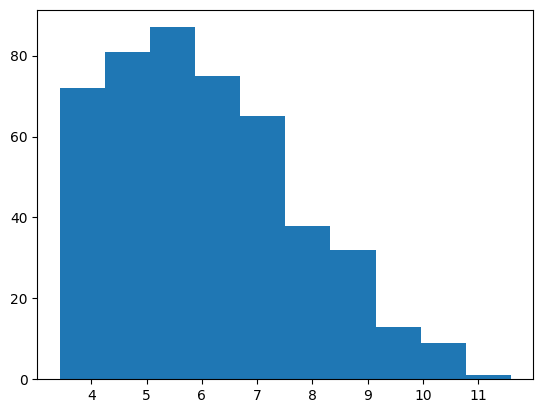

In [318]:
# label marginal distribution: we can see that the label is very skewed and with a lot of zeros that's why is use the transformation log(x+1)

plt.hist(np.log(y_train[y_train>0]+1))
plt.show()

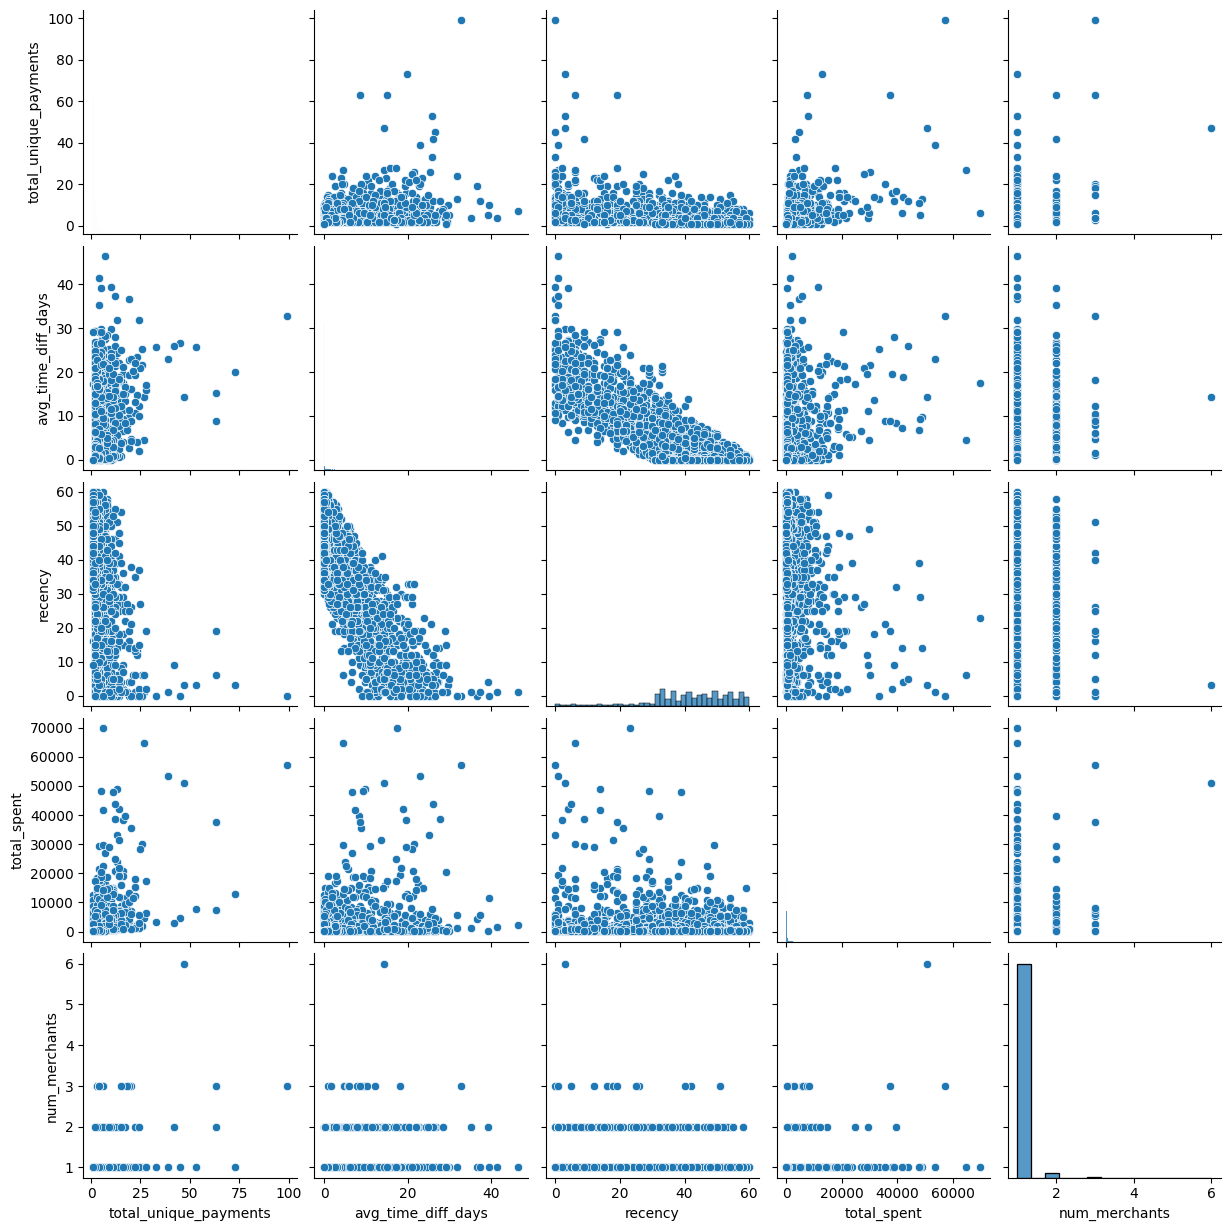

In [319]:
# Select a subset of features to avoid excessive plotting (e.g., top 5 correlated)
selected_features = X_train.corr().abs().sum().sort_values(ascending=False).index[:5]  # Select top 5 strongest correlations

# Create a pairplot for the selected features
sns.pairplot(X_train[selected_features])
plt.show()


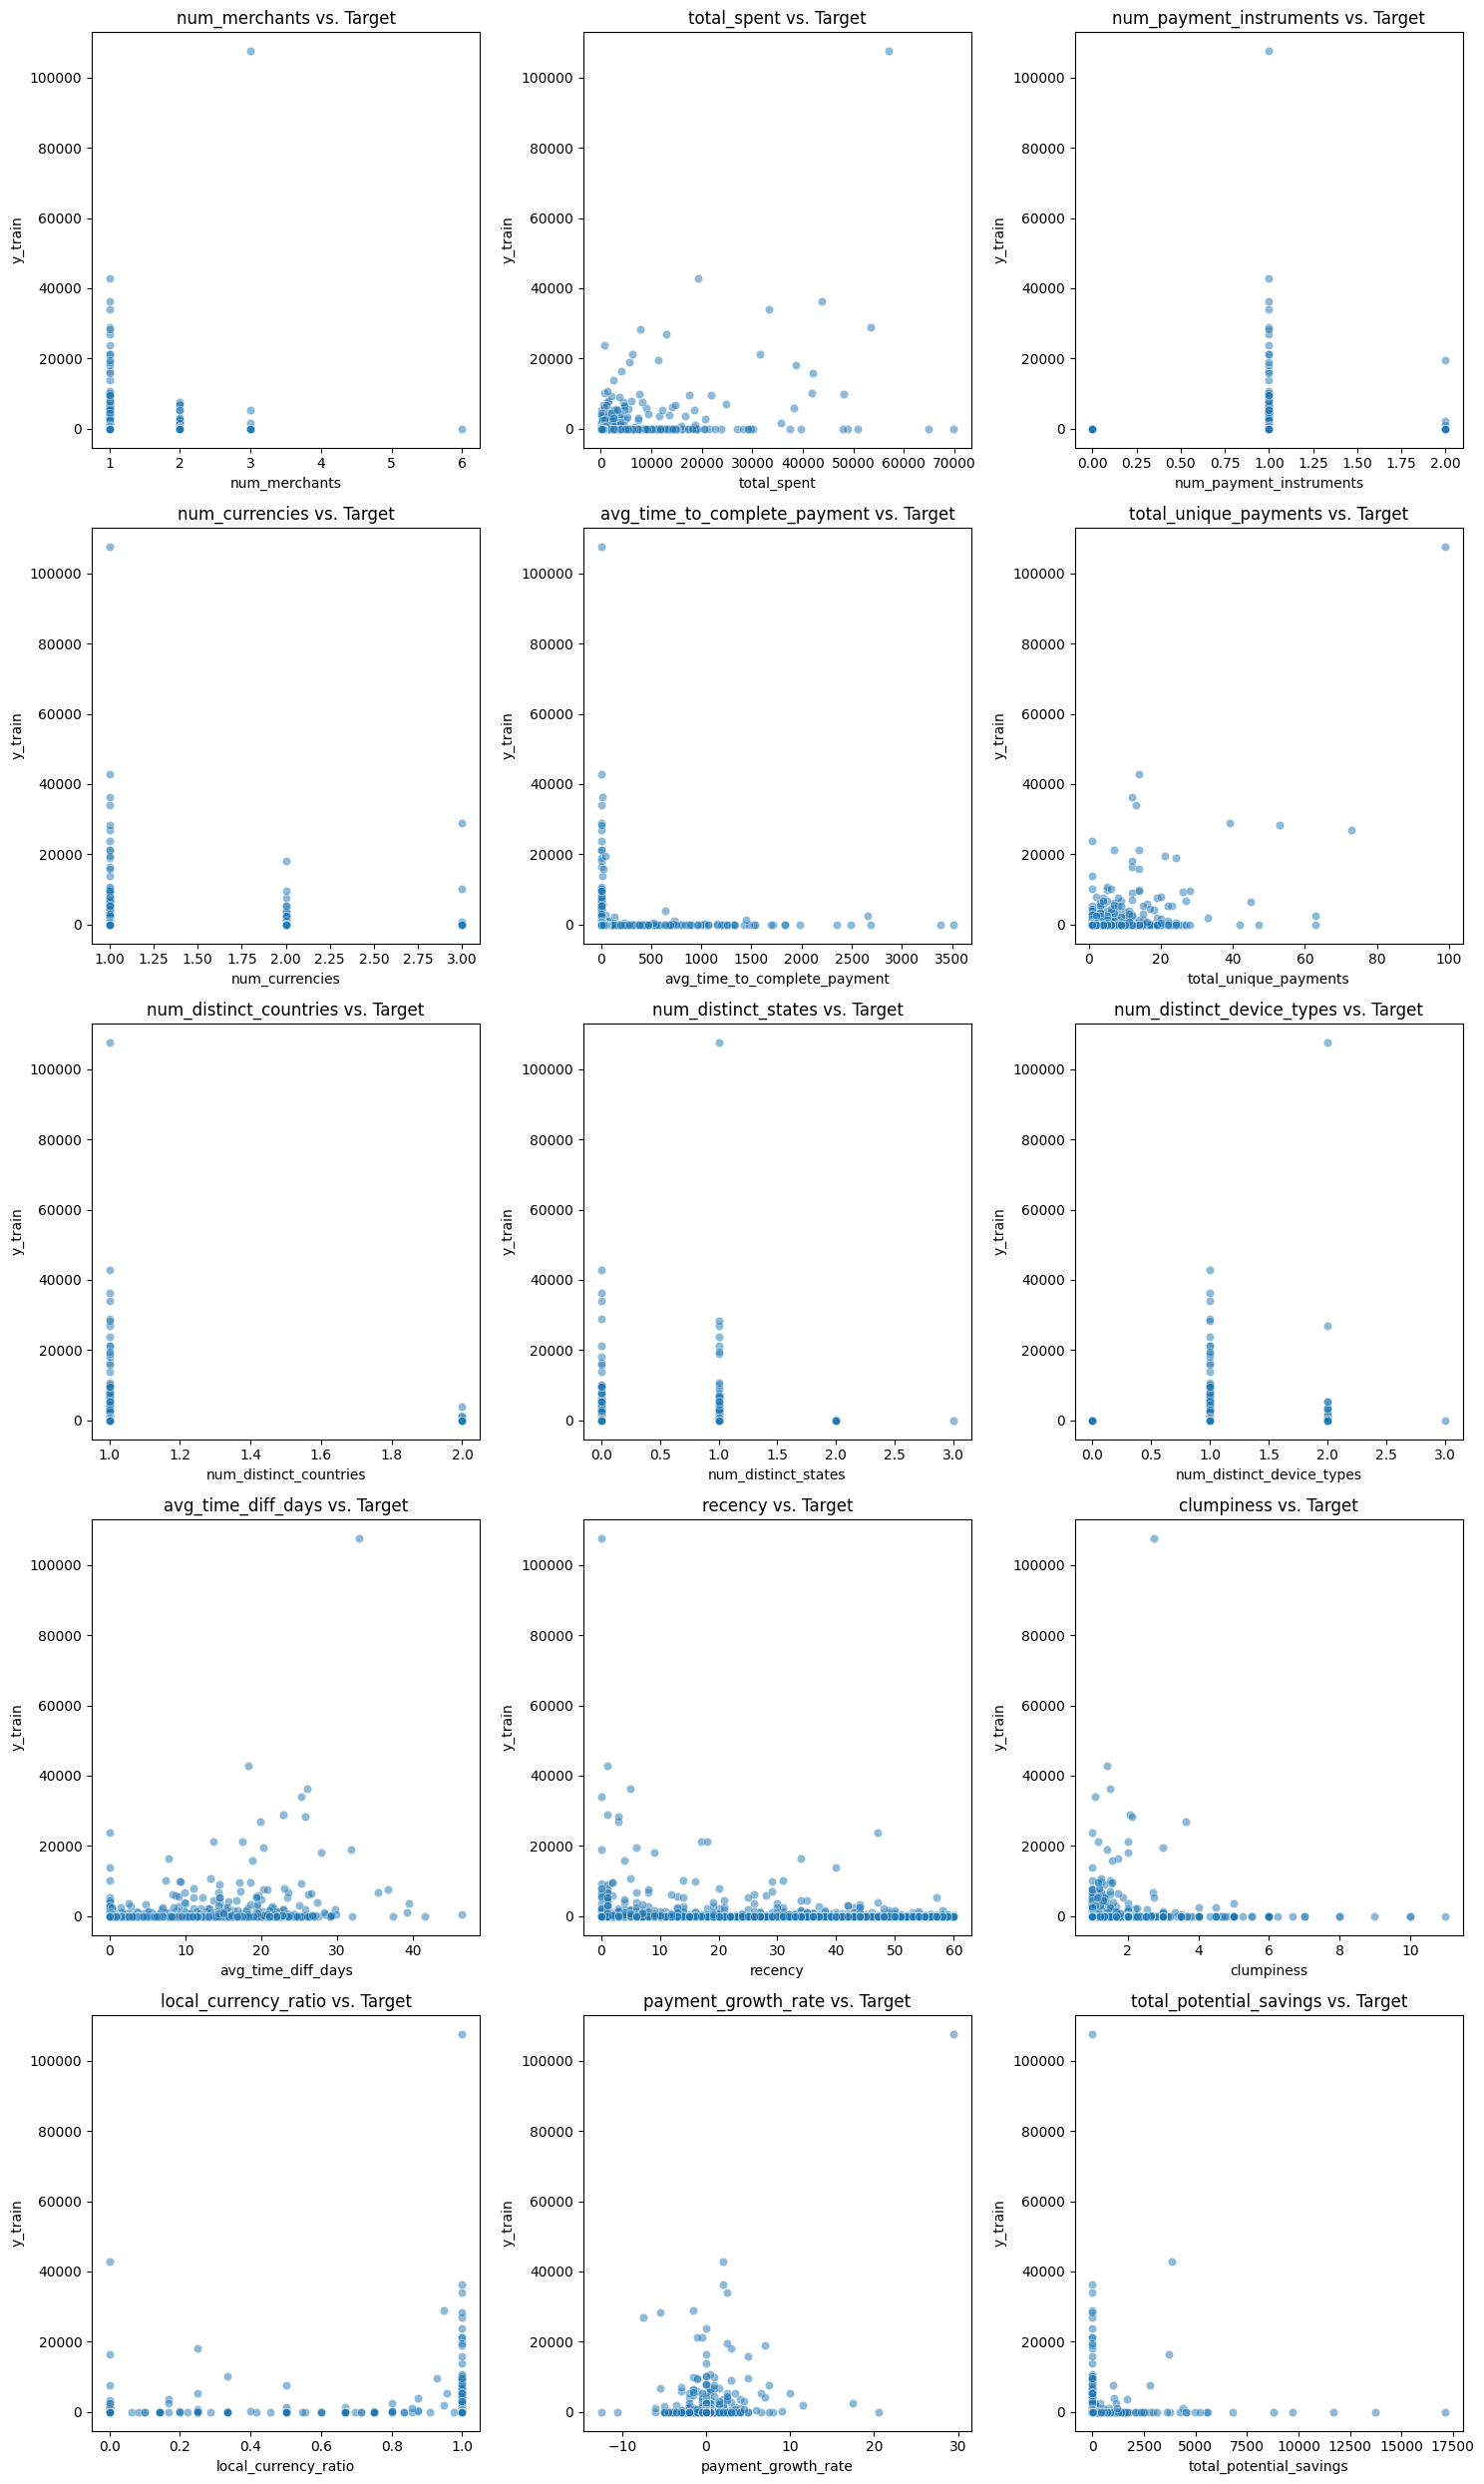

In [320]:
# Set the number of rows and columns for subplots
num_features = len(X_train.columns)
num_cols = 3  # Set number of columns for subplots
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Calculate required rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over each feature and plot scatterplots
for i, feature in enumerate(X_train.columns):
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs. Target")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("y_train")

# Remove empty subplots if features are less than grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- setting seems not linear (low correlation between predictors and label)
- we don't have missing values
- we don't have categorical values
- we do have some features that are skewed (e.g. total_unique_payments, num_currencies)
- we have features on different scales (e.g. total_spent, num_merchants)
- the label is highly skewed
- tree based features are robust to outliers and scale, skewed features.
- feature space 15 is already reduced - so let's start with this as a baseline

In [321]:
X_train.describe()

,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings
count,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000,7274.00000,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000,7274.000000
mean,1.026808,803.574992,1.000962,1.030382,18.847577,2.147099,1.002475,0.22821,1.015122,1.792084,42.051553,1.233692,0.840955,0.006805,38.370543
std,0.179283,3034.763361,0.053726,0.177941,125.504233,3.209248,0.049687,0.42362,0.130750,4.676059,12.369465,0.620641,0.357623,0.765545,412.098825
min,1.000000,29.200000,0.000000,1.000000,0.470766,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,-12.500000,0.000000
25%,1.000000,64.430000,1.000000,1.000000,2.539713,1.000000,1.000000,0.00000,1.000000,0.000000,35.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,157.460000,1.000000,1.000000,4.310950,1.000000,1.000000,0.00000,1.000000,0.000000,43.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,500.000000,1.000000,1.000000,7.953225,2.000000,1.000000,0.00000,1.000000,0.489280,51.000000,1.000000,1.000000,0.000000,0.000000
max,6.000000,69910.170000,2.000000,3.000000,3515.952244,99.000000,2.000000,3.00000,3.000000,46.495536,60.000000,11.000000,1.000000,29.500000,17131.071429


In [322]:
# non-linear baseline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
# Step 2: Train a Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 3: Make Predictions
y_train_pred = rf.predict(X_train)
y_dev_pred = rf.predict(X_dev)

# Step 4: Evaluate the Model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_mae = mean_absolute_error(y_dev, y_dev_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev MAE: {dev_mae:.4f}")
print(f"Dev R²: {dev_r2:.4f}")

Train RMSE: 577.5788
Dev RMSE: 1848.1442
Dev MAE: 213.0808
Dev R²: 0.1997


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


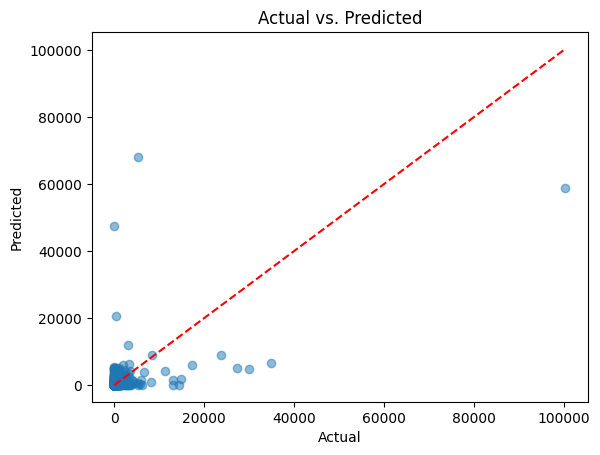

In [323]:
plt.scatter(y_dev, y_dev_pred, alpha=0.5)
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()



- interaction features + polynomial features
- scaling, log transformation of features features - rarely needed
- log transformation of target - sometimes useful
- outliers - handled by tree based models, but can inspect and drop/cap
- multicolinearity - we don't have particularly highly correlated features
- feature selection
- tuning

In [324]:
X_train.columns

Index(['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings'],
      dtype='object')

In [325]:
X_train['spending_per_payment'] = X_train['total_spent'] / X_train['total_unique_payments']
X_train['payment_instruments_per_merchant'] = X_train['num_payment_instruments'] / X_train['num_merchants']
X_train['payments_per_merchant'] = X_train['total_unique_payments'] / X_train['num_merchants']
X_train['spending_per_merchant'] = X_train['total_spent'] / X_train['num_merchants']
X_train['devices_per_country'] = X_train['num_distinct_device_types'] / X_train['num_distinct_countries']
X_train['interaction_recency_clumpiness'] = X_train['recency'] * X_train['clumpiness']
X_train['spending_per_country'] = X_train['total_spent'] / X_train['num_distinct_countries']
X_train['growth_adjusted_spending'] = X_train['total_spent'] * X_train['payment_growth_rate']

In [326]:
X_dev['spending_per_payment'] = X_dev['total_spent'] / X_dev['total_unique_payments']
X_dev['payment_instruments_per_merchant'] = X_dev['num_payment_instruments'] / X_dev['num_merchants']
X_dev['payments_per_merchant'] = X_dev['total_unique_payments'] / X_dev['num_merchants']
X_dev['spending_per_merchant'] = X_dev['total_spent'] / X_dev['num_merchants']
X_dev['devices_per_country'] = X_dev['num_distinct_device_types'] / X_dev['num_distinct_countries']
X_dev['interaction_recency_clumpiness'] = X_dev['recency'] * X_dev['clumpiness']
X_dev['spending_per_country'] = X_dev['total_spent'] / X_dev['num_distinct_countries']
X_dev['growth_adjusted_spending'] = X_dev['total_spent'] * X_dev['payment_growth_rate']

In [327]:
X_test['spending_per_payment'] = X_test['total_spent'] / X_test['total_unique_payments']
X_test['payment_instruments_per_merchant'] = X_test['num_payment_instruments'] / X_test['num_merchants']
X_test['payments_per_merchant'] = X_test['total_unique_payments'] / X_test['num_merchants']
X_test['spending_per_merchant'] = X_test['total_spent'] / X_test['num_merchants']
X_test['devices_per_country'] = X_test['num_distinct_device_types'] / X_test['num_distinct_countries']
X_test['interaction_recency_clumpiness'] = X_test['recency'] * X_test['clumpiness']
X_test['spending_per_country'] = X_test['total_spent'] / X_test['num_distinct_countries']
X_test['growth_adjusted_spending'] = X_test['total_spent'] * X_test['payment_growth_rate']

In [328]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 3: Make Predictions
y_train_pred = rf.predict(X_train)
y_dev_pred = rf.predict(X_dev)

# Step 4: Evaluate the Model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_mae = mean_absolute_error(y_dev, y_dev_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev MAE: {dev_mae:.4f}")
print(f"Dev R²: {dev_r2:.4f}")

Train RMSE: 645.5713
Dev RMSE: 1707.9644
Dev MAE: 208.2671
Dev R²: 0.3165


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [393]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_dev_poly = poly.transform(X_dev)
X_test_poly = poly.transform(X_test)

In [394]:
# Step 2: Train a Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_poly, y_train)

# Step 3: Make Predictions
y_train_pred = rf.predict(X_train_poly)
y_dev_pred = rf.predict(X_dev_poly)

# Step 4: Evaluate the Model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_mae = mean_absolute_error(y_dev, y_dev_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev MAE: {dev_mae:.4f}")
print(f"Dev R²: {dev_r2:.4f}")

Train RMSE: 574.6538
Dev RMSE: 1464.5527
Dev MAE: 200.5628
Dev R²: 0.4975


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


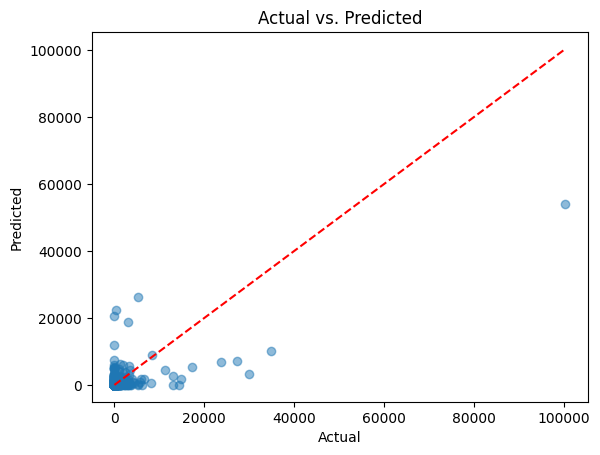

In [395]:
plt.scatter(y_dev, y_dev_pred, alpha=0.5)
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [396]:
# import numpy as np
# from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#
# # Define a function for training and evaluating models
# def train_and_evaluate(model, model_name, X_train, X_dev, y_train, y_dev):
#     # Train model
#     model.fit(X_train, y_train)
#
#     # Make predictions
#     y_train_pred = model.predict(X_train)
#     y_dev_pred = model.predict(X_dev)
#
#     # Evaluate performance
#     train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
#     dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
#     dev_mae = mean_absolute_error(y_dev, y_dev_pred)
#     dev_r2 = r2_score(y_dev, y_dev_pred)
#
#     print(f"=== {model_name} Performance ===")
#     print(f"Train RMSE: {train_rmse:.4f}")
#     print(f"Dev RMSE: {dev_rmse:.4f}")
#     print(f"Dev MAE: {dev_mae:.4f}")
#     print(f"Dev R²: {dev_r2:.4f}\n")
#
# # Models to test
# models = {
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
#     "CatBoost": CatBoostRegressor(iterations=100, verbose=0, random_seed=42),
#     "LightGBM": LGBMRegressor(n_estimators=100, verbose=0, random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
# }
#
# # Train and evaluate each model
# for model_name, model in models.items():
#     train_and_evaluate(model, model_name, X_train_poly, X_dev_poly, y_train, y_dev)

In [397]:
# import shap
#
# # Train Random Forest
# rf.fit(X_train_poly, y_train)
#
# # Initialize SHAP explainer
# explainer = shap.TreeExplainer(rf)
#
# # Compute SHAP values
# shap_values = explainer.shap_values(X_train_poly)
#
# # Summary plot
# shap.summary_plot(shap_values, X_train_poly)


In [398]:
X_train_poly = pd.DataFrame(X_train_poly)
X_dev_poly = pd.DataFrame(X_dev_poly)

In [399]:
# # Calculate mean absolute SHAP values
# shap_importance = np.abs(shap_values).mean(axis=0)
#
# # Create a DataFrame for feature importance
# shap_importance_df = pd.DataFrame({
#     'Feature': X_train_poly.columns,
#     'SHAP Importance': shap_importance
# })
#
# # Sort features by importance
# shap_importance_df = shap_importance_df.sort_values(by='SHAP Importance', ascending=False)
#
# # Extract the top N features
# top_features = shap_importance_df.head(20)['Feature'].tolist()
# print("Top Features:", top_features)

In [400]:
# # Step 2: Train a Random Forest Model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_poly[top_features], y_train)
#
# # Step 3: Make Predictions
# y_train_pred = rf.predict(X_train_poly[top_features])
# y_dev_pred = rf.predict(X_dev_poly[top_features])
#
# # Step 4: Evaluate the Model
# train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
# dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
# dev_mae = mean_absolute_error(y_dev, y_dev_pred)
# dev_r2 = r2_score(y_dev, y_dev_pred)
#
# print(f"Train RMSE: {train_rmse:.4f}")
# print(f"Dev RMSE: {dev_rmse:.4f}")
# print(f"Dev MAE: {dev_mae:.4f}")
# print(f"Dev R²: {dev_r2:.4f}")

In [451]:
# X_train_poly.describe()

In [452]:
# from sklearn.feature_selection import VarianceThreshold
#
# # Apply variance threshold
# threshold = 0.03
# selector = VarianceThreshold(threshold=threshold)
# X_train_reduced = selector.fit_transform(X_train_poly)
# X_dev_reduced = selector.transform(X_dev_poly)
#
# # Get selected features
# selected_features = X_train_poly.columns[selector.get_support()]
# print("Selected Features:", selected_features)


In [453]:
# X_train_poly.shape, X_train_reduced.shape, X_dev_poly.shape, X_dev_reduced.shape

In [454]:
# # Step 2: Train a Random Forest Model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_reduced, y_train)
#
# # Step 3: Make Predictions
# y_train_pred = rf.predict(X_train_reduced)
# y_dev_pred = rf.predict(X_dev_reduced)
#
# # Step 4: Evaluate the Model
# train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
# dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
# dev_mae = mean_absolute_error(y_dev, y_dev_pred)
# dev_r2 = r2_score(y_dev, y_dev_pred)
#
# print(f"Train RMSE: {train_rmse:.4f}")
# print(f"Dev RMSE: {dev_rmse:.4f}")
# print(f"Dev MAE: {dev_mae:.4f}")
# print(f"Dev R²: {dev_r2:.4f}")

In [455]:
# plt.scatter(y_dev, y_dev_pred, alpha=0.5)
# plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
# plt.title("Actual vs. Predicted")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.show()

In [456]:
# X_train_reduced = pd.DataFrame(X_train_reduced)
# X_dev_reduced = pd.DataFrame(X_dev_reduced)

In [457]:
# # Compute correlation matrix
# correlation_matrix = X_train_reduced.corr()
#
# # Find pairs of highly correlated features
# threshold = 0.85
# high_correlation_pairs = np.where(np.abs(correlation_matrix) > threshold)
#
# # Remove one feature from each pair
# features_to_remove = set()
# for i, j in zip(*high_correlation_pairs):
#     if i != j and i not in features_to_remove:
#         features_to_remove.add(j)
#
# # Filter features
# X_train_reduced_cor = X_train_reduced.drop(columns=list(features_to_remove))
# X_dev_reduced_cor = X_dev_reduced.drop(columns=list(features_to_remove))

In [458]:
# X_train_poly.shape, X_train_reduced.shape, X_train_reduced_cor.shape

In [459]:
# # Step 2: Train a Random Forest Model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_reduced_cor, y_train)
#
# # Step 3: Make Predictions
# y_train_pred = rf.predict(X_train_reduced_cor)
# y_dev_pred = rf.predict(X_dev_reduced_cor)
#
# # Step 4: Evaluate the Model
# train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
# dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
# dev_mae = mean_absolute_error(y_dev, y_dev_pred)
# dev_r2 = r2_score(y_dev, y_dev_pred)
#
# print(f"Train RMSE: {train_rmse:.4f}")
# print(f"Dev RMSE: {dev_rmse:.4f}")
# print(f"Dev MAE: {dev_mae:.4f}")
# print(f"Dev R²: {dev_r2:.4f}")
#
# #if we do only corr we go to 0.4759 with 73 features. if we do var+corr we go to 0.4625 and 68 features


In [460]:
# plt.scatter(y_dev, y_dev_pred, alpha=0.5)
# plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
# plt.title("Actual vs. Predicted")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.show()

In [444]:
# Compute correlation matrix
correlation_matrix = X_train_poly.corr()

# Find pairs of highly correlated features
threshold = 0.85
high_correlation_pairs = np.where(np.abs(correlation_matrix) > threshold)

# Remove one feature from each pair
features_to_remove = set()
for i, j in zip(*high_correlation_pairs):
    if i != j and i not in features_to_remove:
        features_to_remove.add(j)

# Filter features
X_train_reduced = X_train_poly.drop(columns=list(features_to_remove))
X_dev_reduced = X_dev_poly.drop(columns=list(features_to_remove))

In [445]:
X_train_reduced.shape, X_train_poly.shape

((7274, 73), (7274, 276))

In [446]:
# Step 2: Train a Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train)

# Step 3: Make Predictions
y_train_pred = rf.predict(X_train_reduced)
y_dev_pred = rf.predict(X_dev_reduced)

# Step 4: Evaluate the Model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_mae = mean_absolute_error(y_dev, y_dev_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev MAE: {dev_mae:.4f}")
print(f"Dev R²: {dev_r2:.4f}")



Train RMSE: 581.4872
Dev RMSE: 1495.6390
Dev MAE: 196.6355
Dev R²: 0.4759


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


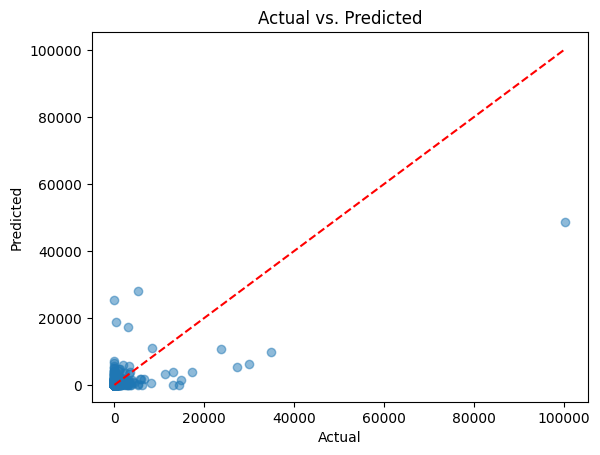

In [447]:
plt.scatter(y_dev, y_dev_pred, alpha=0.5)
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [449]:
X_test_poly = pd.DataFrame(X_test_poly)

In [450]:
X_test_reduced = X_test_poly.drop(columns=list(features_to_remove))

In [389]:
# from sklearn.feature_selection import RFE
# rfe = RFE(estimator=rf, n_features_to_select=20)
# X_train_reduced = rfe.fit_transform(X_train_poly, y_train)
# print("Selected Features:", X_train_poly.columns[rfe.support_])
# X_dev_reduced = rfe.transform(X_dev_poly)

In [390]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_reduced, y_train)
#
# # Step 3: Make Predictions
# y_train_pred = rf.predict(X_train_reduced)
# y_dev_pred = rf.predict(X_dev_reduced)
#
# # Step 4: Evaluate the Model
# train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
# dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
# dev_mae = mean_absolute_error(y_dev, y_dev_pred)
# dev_r2 = r2_score(y_dev, y_dev_pred)
#
# print(f"Train RMSE: {train_rmse:.4f}")
# print(f"Dev RMSE: {dev_rmse:.4f}")
# print(f"Dev MAE: {dev_mae:.4f}")
# print(f"Dev R²: {dev_r2:.4f}")

In [391]:
# from sklearn.feature_selection import mutual_info_regression
#
# # Compute mutual information
# mi = mutual_info_regression(X_train_poly, y_train)
#
# # Rank features by mutual information
# mi_df = pd.DataFrame({
#     'Feature': X_train_poly.columns,
#     'Mutual_Information': mi
# }).sort_values(by='Mutual_Information', ascending=False)
# top_features = mi_df.sort_values(by='Mutual_Information', ascending=False).head(50)

In [392]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_poly[top_features.Feature], y_train)
#
# # Step 3: Make Predictions
# y_train_pred = rf.predict(X_train_poly[top_features.Feature])
# y_dev_pred = rf.predict(X_dev_poly[top_features.Feature])
#
# # Step 4: Evaluate the Model
# train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
# dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
# dev_mae = mean_absolute_error(y_dev, y_dev_pred)
# dev_r2 = r2_score(y_dev, y_dev_pred)
#
# print(f"Train RMSE: {train_rmse:.4f}")
# print(f"Dev RMSE: {dev_rmse:.4f}")
# print(f"Dev MAE: {dev_mae:.4f}")
# print(f"Dev R²: {dev_r2:.4f}")

In [498]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [5, 8, 10],       # Maximum depth of each tree
    'min_samples_split': [10, 20, 30],       # Minimum samples required to split an internal node
    'min_samples_leaf': [5, 10],         # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider for splitting
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to try
    scoring='neg_root_mean_squared_error',  # Scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Perform Randomized Search
random_search.fit(X_train_poly, y_train)

# Best parameters and model performance
best_params = random_search.best_params_
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_poly)
y_dev_pred = best_model.predict(X_dev_poly)

# Evaluate performance on the dev set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Best Parameters: {best_params}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Dev R²: {dev_r2:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5}
Train RMSE: 1261.3840
Dev RMSE: 1712.2575
Train R²: 0.5120
Dev R²: 0.3131


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [517]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [5, 8, 10],       # Maximum depth of each tree
    'min_samples_split': [10, 20, 30],       # Minimum samples required to split an internal node
    'min_samples_leaf': [5, 10],         # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider for splitting
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to try
    scoring='neg_root_mean_squared_error',  # Scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Perform Randomized Search
random_search.fit(X_train_reduced, y_train)

# Best parameters and model performance
best_params = random_search.best_params_
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_reduced)
y_dev_pred = best_model.predict(X_dev_reduced)

# Evaluate performance on the dev set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Best Parameters: {best_params}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Dev R²: {dev_r2:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5}
Train RMSE: 1318.7528
Dev RMSE: 1713.9277
Train R²: 0.4666
Dev R²: 0.3117


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


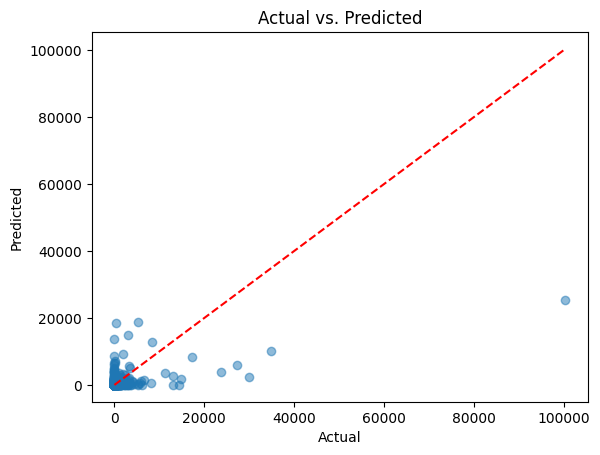

In [499]:
plt.scatter(y_dev, y_dev_pred, alpha=0.5)
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')  # Perfect prediction line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

i want to assess how well the model does for each type of users, high, medium and low LTV. we want the model to predict well specifically the high-LTV users, and if we need to express a preference on how the model mispredict, we prefer that the model predicts a higher value than the actual one instead of the inverse. if the model predicts a lower value than the actual one, then the damage is worse because Nuvei cannot share this user with the merchants for ad-targeting, when in reality this user constitutes a source of potential revenue: e.g. the user that has an actual LTV of 100,000 but predicted 20,000. So even if the predictions and labels are not precisely on the diagonal line, we would prefer that most of the predictions are above and not below.

In [500]:
# Combine actual and predicted values for dev set
dev_results = pd.DataFrame({
    'Actual': y_dev,
    'Predicted': y_dev_pred
})

# Define thresholds for LTV segmentation (use quantiles or domain knowledge)
low_threshold = y_dev.drop_duplicates().describe()['25%']
high_threshold = y_dev.drop_duplicates().describe()['75%']

# Create LTV categories
def categorize_ltv(value):
    if value <= low_threshold:
        return 'Low LTV'
    elif value <= high_threshold:
        return 'Medium LTV'
    else:
        return 'High LTV'

dev_results['LTV Category'] = dev_results['Actual'].apply(categorize_ltv)

# Check the distribution of users in each category
print(dev_results['LTV Category'].value_counts())


LTV Category
Low LTV       3410
Medium LTV     117
High LTV        57
Name: count, dtype: int64


In [501]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Group by LTV Category
grouped_results = dev_results.groupby('LTV Category')

# Compute metrics for each group
for category, group in grouped_results:
    actual = group['Actual']
    predicted = group['Predicted']
    mae = mean_absolute_error(actual, predicted)
    mape = (abs(actual - predicted) / actual).mean() * 100
    msle = mean_squared_error(np.log1p(actual), np.log1p(predicted))  # Log-based RMSE
    rmse = mean_squared_error(actual, predicted, squared=False)
    r2 = r2_score(actual, predicted)

    print(f"\nLTV Category: {category}")
    print(f"  MAE: {mae:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  MSLE: {msle:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R^2: {r2:.2f}")



LTV Category: High LTV
  MAE: 6652.71
  MAPE: 89.68%
  MSLE: 6.7348
  RMSE: 12860.97
  R^2: 0.20

LTV Category: Low LTV
  MAE: 80.48
  MAPE: inf%
  MSLE: 13.0692
  RMSE: 434.22
  R^2: -1806.59

LTV Category: Medium LTV
  MAE: 720.60
  MAPE: 204.40%
  MSLE: 4.2961
  RMSE: 1931.88
  R^2: -26.01


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


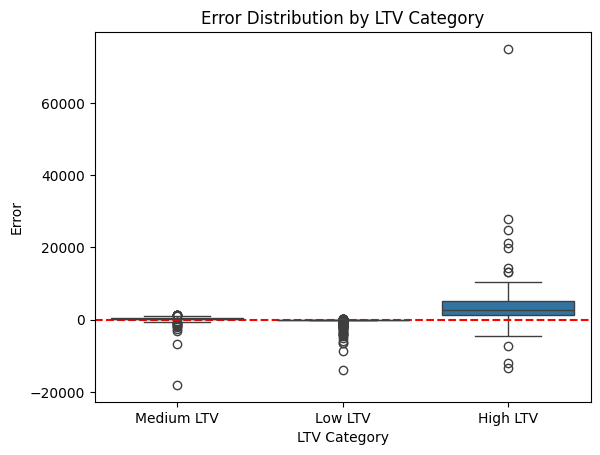

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_8767/3734810460.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_metrics = grouped_results.apply(lambda x: pd.Series({


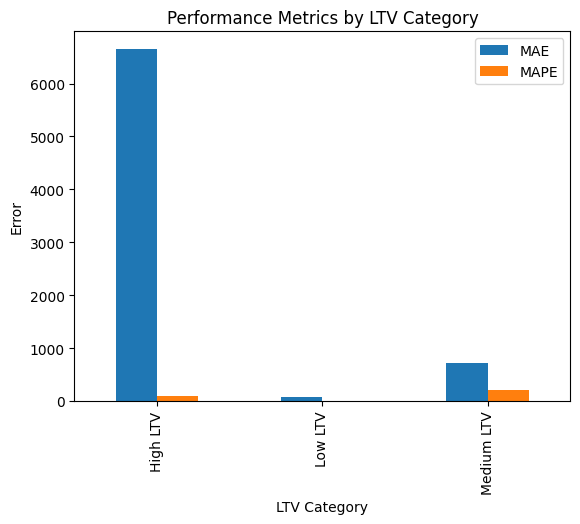

In [502]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of errors by LTV category
dev_results['Error'] = dev_results['Actual'] - dev_results['Predicted']
sns.boxplot(x='LTV Category', y='Error', data=dev_results)
plt.title("Error Distribution by LTV Category")
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Bar plot of MAE and MAPE
grouped_metrics = grouped_results.apply(lambda x: pd.Series({
    'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
    'MAPE': (abs(x['Actual'] - x['Predicted']) / x['Actual']).mean() * 100
}))
grouped_metrics.plot(kind='bar', title="Performance Metrics by LTV Category")
plt.ylabel("Error")
plt.show()


In [509]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# LightGBM Dataset
train_data = lgb.Dataset(X_train_poly, label=y_train)
dev_data = lgb.Dataset(X_dev_poly, label=y_dev)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8
}

# Train LightGBM
lgb_model = lgb.train(params, train_data, valid_sets=[dev_data], num_boost_round=500)

# Predictions
y_dev_pred = lgb_model.predict(X_dev_poly)

# Evaluation

mae = mean_absolute_error(y_dev, y_dev_pred)
# mape = (abs(y_dev - y_dev_pred) / y_dev).mean() * 100
# msle = mean_squared_error(np.log1p(y_dev), np.log1p(y_dev_pred))  # Log-based RMSE
rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
r2 = r2_score(y_dev, y_dev_pred)

print(f"\nLTV Category: {category}")
print(f"  MAE: {mae:.2f}")
# print(f"  MAPE: {mape:.2f}%")
# print(f"  MSLE: {msle:.4f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R^2: {r2:.2f}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [512]:
import keras
from keras import layers
from keras import optimizers
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_dev_scaled = scaler.transform(X_dev_poly)

# Build the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_dev_scaled, y_dev), epochs=50, batch_size=32)

# Predictions
y_dev_pred = model.predict(X_dev_scaled).flatten()

# Evaluation
rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Deep Learning Dev RMSE: {rmse:.4f}")
print(f"Deep Learning Dev R^2: {dev_r2:.4f}")

Epoch 1/50


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5859480.0000 - mse: 5859480.0000 - val_loss: 3252442.2500 - val_mse: 3252442.2500
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1659025.1250 - mse: 1659025.1250 - val_loss: 1558445.6250 - val_mse: 1558445.6250
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1153018.6250 - mse: 1153018.6250 - val_loss: 1332068.7500 - val_mse: 1332068.7500
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1409407.1250 - mse: 1409407.1250 - val_loss: 2444425.5000 - val_mse: 2444425.5000
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4094342.0000 - mse: 4094342.0000 - val_loss: 3071169.2500 - val_mse: 3071169.2500
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2586167.2500 - mse: 2586167.2500 - val_loss: 8739549.0000 - val_mse: 8739549.0000
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1374426.3750 - mse: 1374426.3750 - val_loss: 16088306.0000 - val_mse: 16088306.0000
Epoch 8/50
228/

/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [514]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=500,            # Number of boosting rounds
    learning_rate=0.1,         # Learning rate
    depth=6,                   # Depth of the trees
    loss_function='RMSE',      # Loss function to optimize
    eval_metric='RMSE',        # Evaluation metric
    random_seed=42,            # For reproducibility
    verbose=100                # Show training progress every 100 iterations
)

# Step 2: Train the model
catboost_model.fit(
    X_train_poly, y_train,          # Training data
    eval_set=[(X_train_poly, y_train), (X_dev_poly, y_dev)],   # Validation data
    use_best_model=True,       # Stop early and keep the best model
    early_stopping_rounds=50   # Stop training if no improvement after 50 rounds
)

# Step 3: Make predictions
y_train_pred = catboost_model.predict(X_train_poly)
y_dev_pred = catboost_model.predict(X_dev_poly)

# Step 4: Evaluate the model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_mae = mean_absolute_error(y_dev, y_dev_pred)
dev_r2 = r2_score(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev MAE: {dev_mae:.4f}")
print(f"Dev R²: {dev_r2:.4f}")


0:	learn: 1779.4531429	test: 1779.4531429	test1: 2065.4268326	best: 2065.4268326 (0)	total: 24.9ms	remaining: 12.4s
100:	learn: 645.3081987	test: 645.3081987	test1: 2022.4145493	best: 2020.1192274 (93)	total: 1.68s	remaining: 6.63s
200:	learn: 409.5756078	test: 409.5756078	test1: 2018.7424287	best: 2015.7694706 (152)	total: 3.98s	remaining: 5.92s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2015.769471
bestIteration = 152

Shrink model to first 153 iterations.
Train RMSE: 506.1813
Dev RMSE: 2015.7694
Dev MAE: 214.4984
Dev R²: 0.0480


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [515]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

catboost = CatBoostRegressor(random_seed=42, loss_function='RMSE', verbose=0)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_poly, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

# Best Model Evaluation
best_model = random_search.best_estimator_
y_dev_pred = best_model.predict(X_dev_poly)
dev_rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
dev_r2 = r2_score(y_dev, y_dev_pred)
print(f"Dev RMSE: {dev_rmse:.4f}")
print(f"Dev R²: {dev_r2:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 8, 'border_count': 128}
Dev RMSE: 1943.0665
Dev R²: 0.1154


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [516]:
# let's fit best model on train
y_test_pred = best_model.predict(X_test_poly)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Test RMSE: 1919.8645
Test R²: 0.1794


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


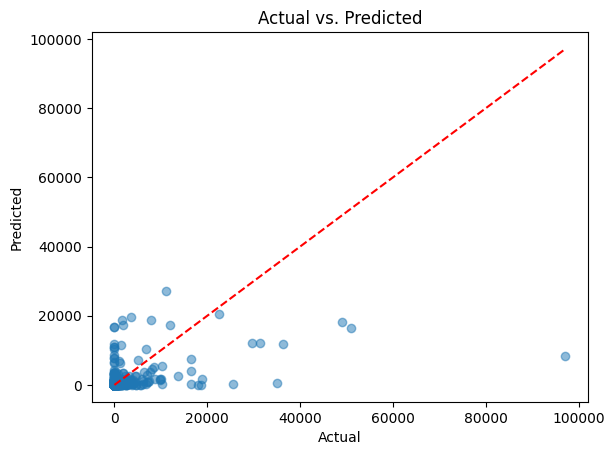

In [504]:
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()